# Imports

In [1]:
import pandas as pd
import sys
sys.path.append(r"C:\Users\silvh\OneDrive\lighthouse\custom_python")
from silvhua import *
import seaborn as sns
import matplotlib.pyplot as plt
from silvhua_plot import *
from PIL import Image
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LassoCV
import re
sys.path.append(r"C:\Users\silvh\OneDrive\lighthouse\projects\lighthouse-capstone-project\src")
from processing_functions import *
from plot_functions import *
from capstone_modelling import *

# load data

In [2]:
path = r'C:\Users\silvh\OneDrive\lighthouse\projects\lighthouse-capstone-project\data'
df_fw = load_csv('data_freeweight_corrected.csv',path, column1_as_index=False)
print(df_fw.shape)
df_fw.head()

Dataframe shape:  (52, 15)
(52, 15)


Age  Mass  Height  Load20%1RM  Load40%1RM  Load60%1RM  Load80%1RM  \
0   22  77.8   175.0        39.0          78       114.0       156.0   
1   21  71.6   179.0        24.0          48        72.0        96.0   
2   19  60.8   165.0        26.0          52        78.0       104.0   
3   21  58.4   172.0        20.0          40        60.0        80.0   
4   20  82.3   185.0        30.0          60        90.0       120.0   

   Load90%1RM  Load-1RM-1  20% MV  40%MV  60%MV  80%MV  90%MV  100%MV  
0       175.0       190.0    1.05   0.91   0.76   0.52   0.39    0.26  
1       108.0       120.0    1.03   0.91   0.68   0.49   0.39    0.27  
2       117.0       130.0    1.06   0.92   0.76   0.51   0.37    0.26  
3        90.0       100.0    0.97   0.85   0.68   0.50   0.38    0.26  
4       135.0       150.0    1.02   0.92   0.76   0.50   0.40    0.29

In [5]:
df_sm = load_csv('data_sm.csv',path, column1_as_index=False)
df_sm.head()

Dataframe shape:  (52, 15)


Age  Mass  Height  Load20%1RM  Load40%1RM  Load60%1RM  Load80%1RM  \
0   22  77.8   175.0        42.0          84       126.0       168.0   
1   21  71.6   179.0        30.0          60        90.0       120.0   
2   19  60.8   165.0        30.0          60        90.0       120.0   
3   21  58.4   172.0        24.0          48        72.0        96.0   
4   20  82.3   185.0        35.0          70       105.0       140.0   

   Load90%1RM  Load-1RM-1  20% MV  40%MV  60%MV  80%MV  90%MV  100%MV  
0       189.0       210.0    1.05   0.92   0.72   0.51   0.40    0.28  
1       135.0       150.0    1.06   0.90   0.67   0.50   0.38    0.26  
2       135.0       150.0    1.09   0.92   0.74   0.48   0.36    0.24  
3       108.0       120.0    1.07   0.91   0.73   0.53   0.42    0.27  
4       157.5       175.0    1.03   0.91   0.70   0.51   0.38    0.29

# Feature engineering

In [4]:
df_fw.columns

Index(['Age', 'Mass', 'Height', 'Load20%1RM', 'Load40%1RM', 'Load60%1RM',
       'Load80%1RM', 'Load90%1RM', 'Load-1RM-1', '20% MV', '40%MV', '60%MV',
       '80%MV', '90%MV', '100%MV'],
      dtype='object')

## `linear_regression` and `individual_regression` functions

In [3]:
# 2022-11-25 10:38 realize I need to reverse the load and velocity for the calculations
# 2022-11-21 0:53 Allow to be used as a stand-alone function or when called with .apply with transposed df.
def linear_regression2(df, loads):
    """2022-11-28 18:22
    Calculate slope and intercept using linear regression, where X = load, y = velocity.
    Function called by other functions: individual_regression() and reshape_group_df_lr(df).
    Can be used as a stand-alone function or when called with .apply with transposed DataFrame.

    Parameters:
        - df: DataFrame with each row containing data for an individual.
        - loads (list): List of relative loads to be used for calculating LV slope and LV intercept.
    Returns:
        Dataframe with the slope and intercept for the linear regression.

    """
    from sklearn.linear_model import LinearRegression

    # Select columns that contain the numbers in load
    regex_MV = ''.join([str(load)+r'%.*MV|' for load in loads])
    regex_load = ''.join([str(load)+r'%1RM|' for load in loads]) 
    if type(df)==pd.Series:
        load = df.filter(regex=regex_load[:-1], axis='index').values.reshape(-1,1)
        velocity = df.filter(regex=regex_MV[:-1], axis='index').values.reshape(-1,1)

        lr = LinearRegression()
        lr.fit(velocity, load)
        
        # LinearRegression attributes are in arrays, so need to access values with indices
        df['slope'] = lr.coef_[0][0] 
        df['intercept'] = lr.intercept_[0]

        return df
    else:
        load = df.filter(regex=regex_load[:-1]).values.reshape(-1,1)
        velocity = df.filter(regex=regex_MV[:-1]).values.reshape(-1,1)
        lr = LinearRegression()
        lr.fit(velocity, load)

        df_lr = pd.DataFrame()
        df_lr['slope'] = lr.coef_[0]
        df_lr['intercept'] = lr.intercept_

        return df_lr

linear_regression2(df_fw.head(1), [40, 80])

slope  intercept
0 -200.0      260.0

In [46]:
df_fw.head(2)

Age  Mass  Height  Load20%1RM  Load40%1RM  Load60%1RM  Load80%1RM  \
0   22  77.8   175.0        39.0          78       114.0       156.0   
1   21  71.6   179.0        24.0          48        72.0        96.0   

   Load90%1RM  Load-1RM-1  20% MV  40%MV  60%MV  80%MV  90%MV  100%MV  
0       175.0       190.0    1.05   0.91   0.76   0.52   0.39    0.26  
1       108.0       120.0    1.03   0.91   0.68   0.49   0.39    0.27

In [20]:
def individual_regression2(df, loads):
    """2022-11-28 20:09

    Necessary for feature engineering.
    Calculate slope and intercept for each row of the dataframe (i.e. for each individual participant)
    by calling the linear_regression2 function.

    Parameters:
        - df: DataFrame with each row containing data for an individual.
        - loads (list): List of relative loads to be used for calculating LV slope and LV intercept.
    Returns:
        Dataframe with new columns added: 
            - 'slope' and 'intercept' for the linear regression for each individual row.
            - 'group MVT': Mean '100%MV' value for the dataset (value identical in each row)
    """
    df_lr = df.transpose().apply(lambda x:linear_regression2(x, loads)).transpose()
    
    df_lr['group MVT'] =  df_lr['100%MV'].mean()
    print('Dataframe shape: ', df_lr.shape)
    return df_lr

individual_regression2(df_fw.head(3), [40, 60])

Dataframe shape:  (3, 18)


Age  Mass  Height  Load20%1RM  Load40%1RM  Load60%1RM  Load80%1RM  \
0  22.0  77.8   175.0        39.0        78.0       114.0       156.0   
1  21.0  71.6   179.0        24.0        48.0        72.0        96.0   
2  19.0  60.8   165.0        26.0        52.0        78.0       104.0   

   Load90%1RM  Load-1RM-1  20% MV  40%MV  60%MV  80%MV  90%MV  100%MV  \
0       175.0       190.0    1.05   0.91   0.76   0.52   0.39    0.26   
1       108.0       120.0    1.03   0.91   0.68   0.49   0.39    0.27   
2       117.0       130.0    1.06   0.92   0.76   0.51   0.37    0.26   

        slope   intercept  group MVT  
0 -240.000000  296.400000   0.263333  
1 -104.347826  142.956522   0.263333  
2 -162.500000  201.500000   0.263333

In [5]:
def reshape_group_df_lr2(df, loads):
    """2022-11-27 20:39
    Necessary for data visualization.
    Reshape dataframe each row represents data from one rep (each participant has multiple columns).
    Add the estimations from the linear regression.

        Parameters:
        - df: DataFrame with one row per participant. 
        - loads (list): List of relative loads to be used for calculating LV slope and LV intercept.
        Returns:
        - DataFrame with each row representing a single set (each participant may have multiple rows). 
        Participants are sorted by strength for compatibility with Seaborn plots.
    """
    # Calculate slope and intercept for each row of the dataframe (i.e. for each individual participant)
    # by calling the linear_regression function.
    print('Original shape: ',df.shape)
    df = df.transpose().apply(lambda x:linear_regression2(x, loads)).transpose()
    
    velocity_columns = df.columns[df.columns.str.contains('MV')]
    load_columns = df.columns[df.columns.str.contains('Load')]

    # Use intercept and slope to calculate predicted load
    for column in velocity_columns:
        df[re.sub('(\d*%).*','\\1 predicted load', column)] = df['slope'] * df[column] + df['intercept']
    
    prediction_columns = df.columns[df.columns.str.contains('predicted load')].to_list()

    # Sort participants by strength
    df = df.sort_values('Load-1RM-1').reset_index(drop=True)
    df2 = pd.concat([
        df.melt(
            value_vars=load_columns, value_name='absolute load',
            ignore_index=False
        ),
        df.melt(
            id_vars='Load-1RM-1',
            value_vars=velocity_columns, var_name='%1RM', value_name='mean velocity',
            ignore_index=False
            ),
    ], axis=1).drop(columns='variable')
    df3 = df.melt(
            # id_vars='Load-1RM-1',
            value_vars=prediction_columns, value_name='predicted load', 
            ignore_index=False
            ).reset_index(drop=True).drop(columns='variable')
    df2['%1RM'] = df2['%1RM'].str.replace('(\d*)\D*','\\1', regex=True).astype(float)
    df2 = df2.rename({'Load-1RM-1':'1RM'}, axis=1)
    df2 = df2.reset_index(names='participant')
    df2 = pd.concat([df2,df3],axis=1)
    print('New shape: ', df2.shape)
    return df2

## Engineer features
For these analyses, use only free weight data

In [37]:
# Get all pair-wise combinations of relative loads
def create_pairs(sortable_list):
    """
    Create all unique pair combinations of 2 elements from a list (exclude pairs where
    the elements are identical)

    Parameters:
        - list (list): List of numbers or strings (or other elements that can be passed into
            the sorted() function).
    Returns:
        List of pair combinations, where each pair combination is in a list.
    """
    from itertools import product
    pairs = list(product(sortable_list, sortable_list))
    pairs = [set(sorted([pair[0], pair[1]])) for pair in pairs if pair[0] != pair[1]]
    unique_pairs = []
    for item in pairs:
        if item not in unique_pairs:
            unique_pairs.append(item)
    unique_pairs = [sorted(list(pair)) for pair in unique_pairs]
    print(f'Number of unique pairs: {len(unique_pairs)}')
    return unique_pairs

loads = [20, 40, 60, 80, 90]
unique_load_pairs = create_pairs(loads)
unique_load_pairs

Number of unique pairs: 10


[[20, 40],
 [20, 60],
 [20, 80],
 [20, 90],
 [40, 60],
 [40, 80],
 [40, 90],
 [60, 80],
 [60, 90],
 [80, 90]]

In [33]:
df20_60 = individual_regression2(df_fw, [20, 60])
df20_80 = individual_regression2(df_fw, [20, 80])
df20_90 = individual_regression2(df_fw, [20, 90])
df40_60 = individual_regression2(df_fw, [40, 60])
df40_80 = individual_regression2(df_fw, [40, 80])
df60_80 = individual_regression2(df_fw, [60, 80])
df60_90 = individual_regression2(df_fw, [60, 90])
df80_90 = individual_regression2(df_fw, [80, 90])

Dataframe shape:  (52, 18)
Dataframe shape:  (52, 18)
Dataframe shape:  (52, 18)
Dataframe shape:  (52, 18)
Dataframe shape:  (52, 18)
Dataframe shape:  (52, 18)
Dataframe shape:  (52, 18)
Dataframe shape:  (52, 18)


## Plot individuals' predicted and measured load velocity profiles 

Original shape:  (52, 15)
New shape:  (312, 6)
Original shape:  (52, 15)
New shape:  (312, 6)
Original shape:  (52, 15)
New shape:  (312, 6)
Original shape:  (52, 15)
New shape:  (312, 6)
Original shape:  (52, 15)
New shape:  (312, 6)
Original shape:  (52, 15)
New shape:  (312, 6)
Original shape:  (52, 15)
New shape:  (312, 6)
Original shape:  (52, 15)
New shape:  (312, 6)
Original shape:  (52, 15)
New shape:  (312, 6)
Original shape:  (52, 15)
New shape:  (312, 6)


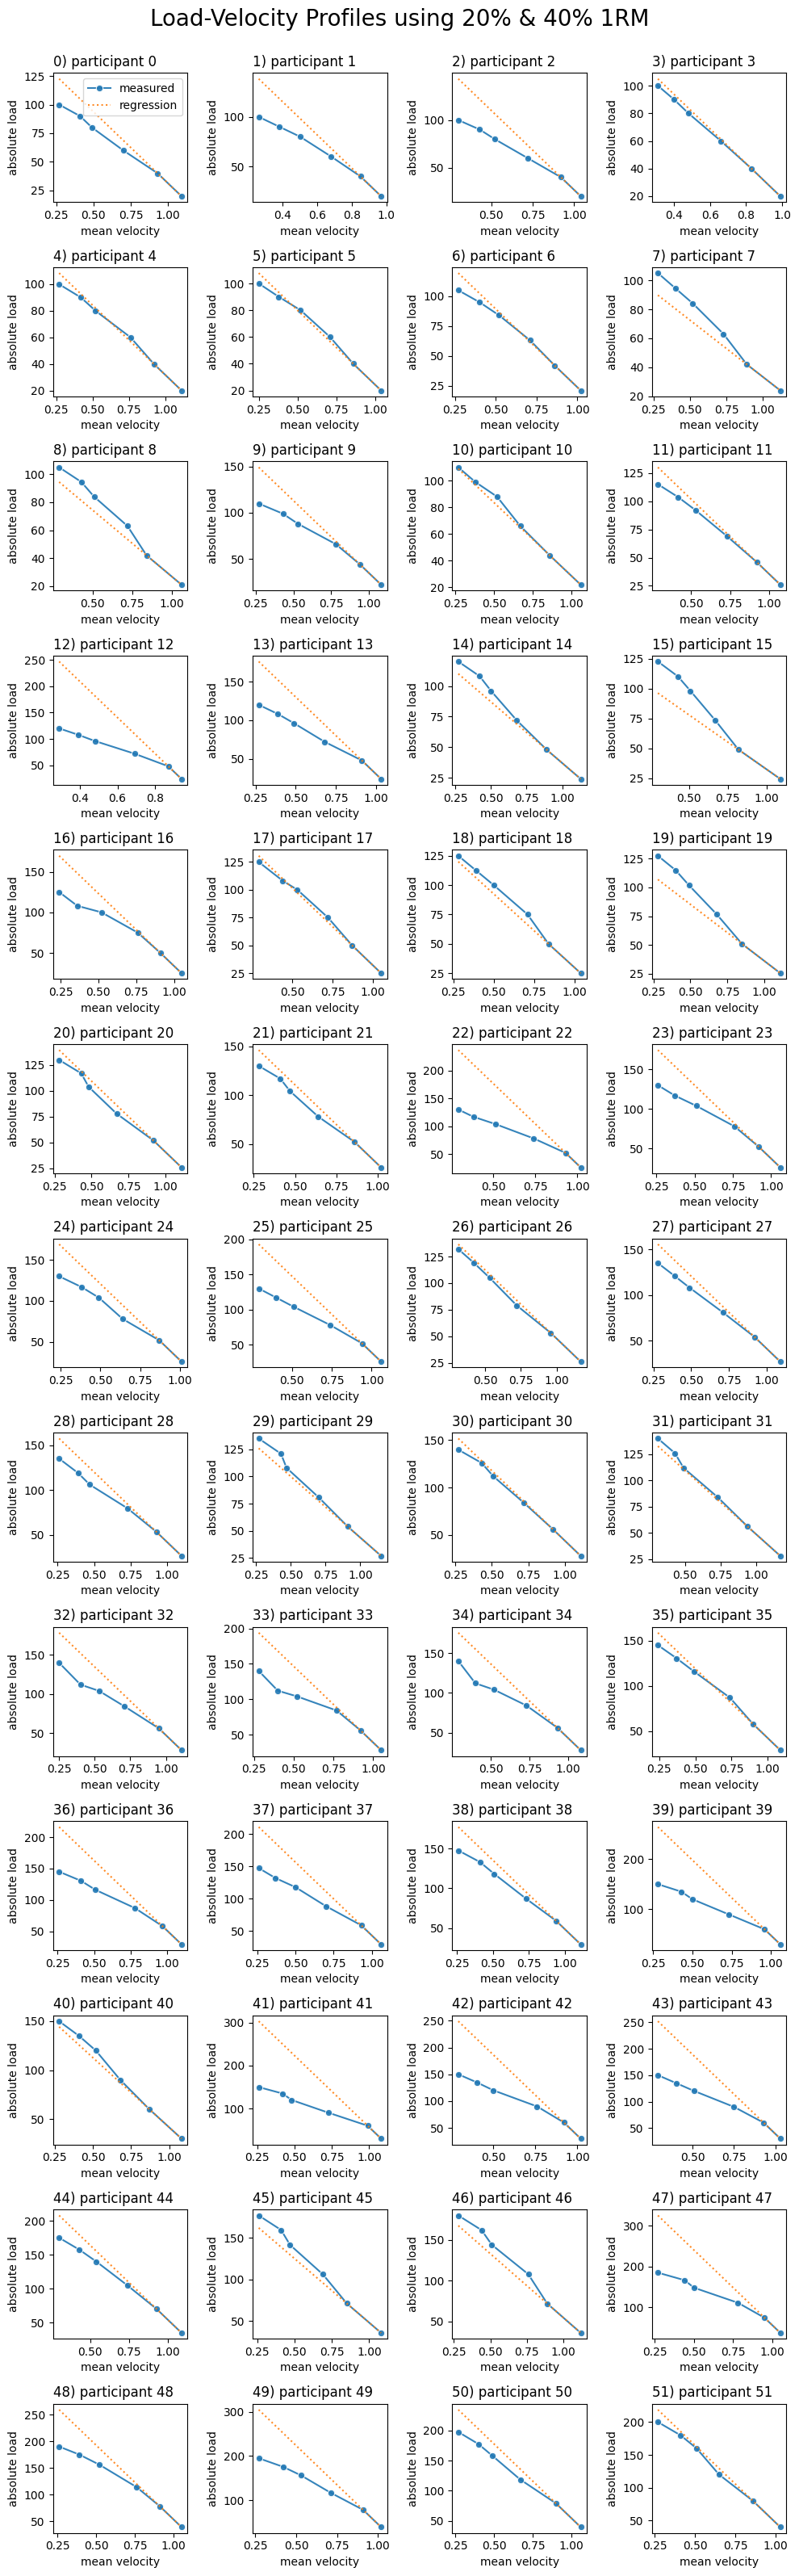

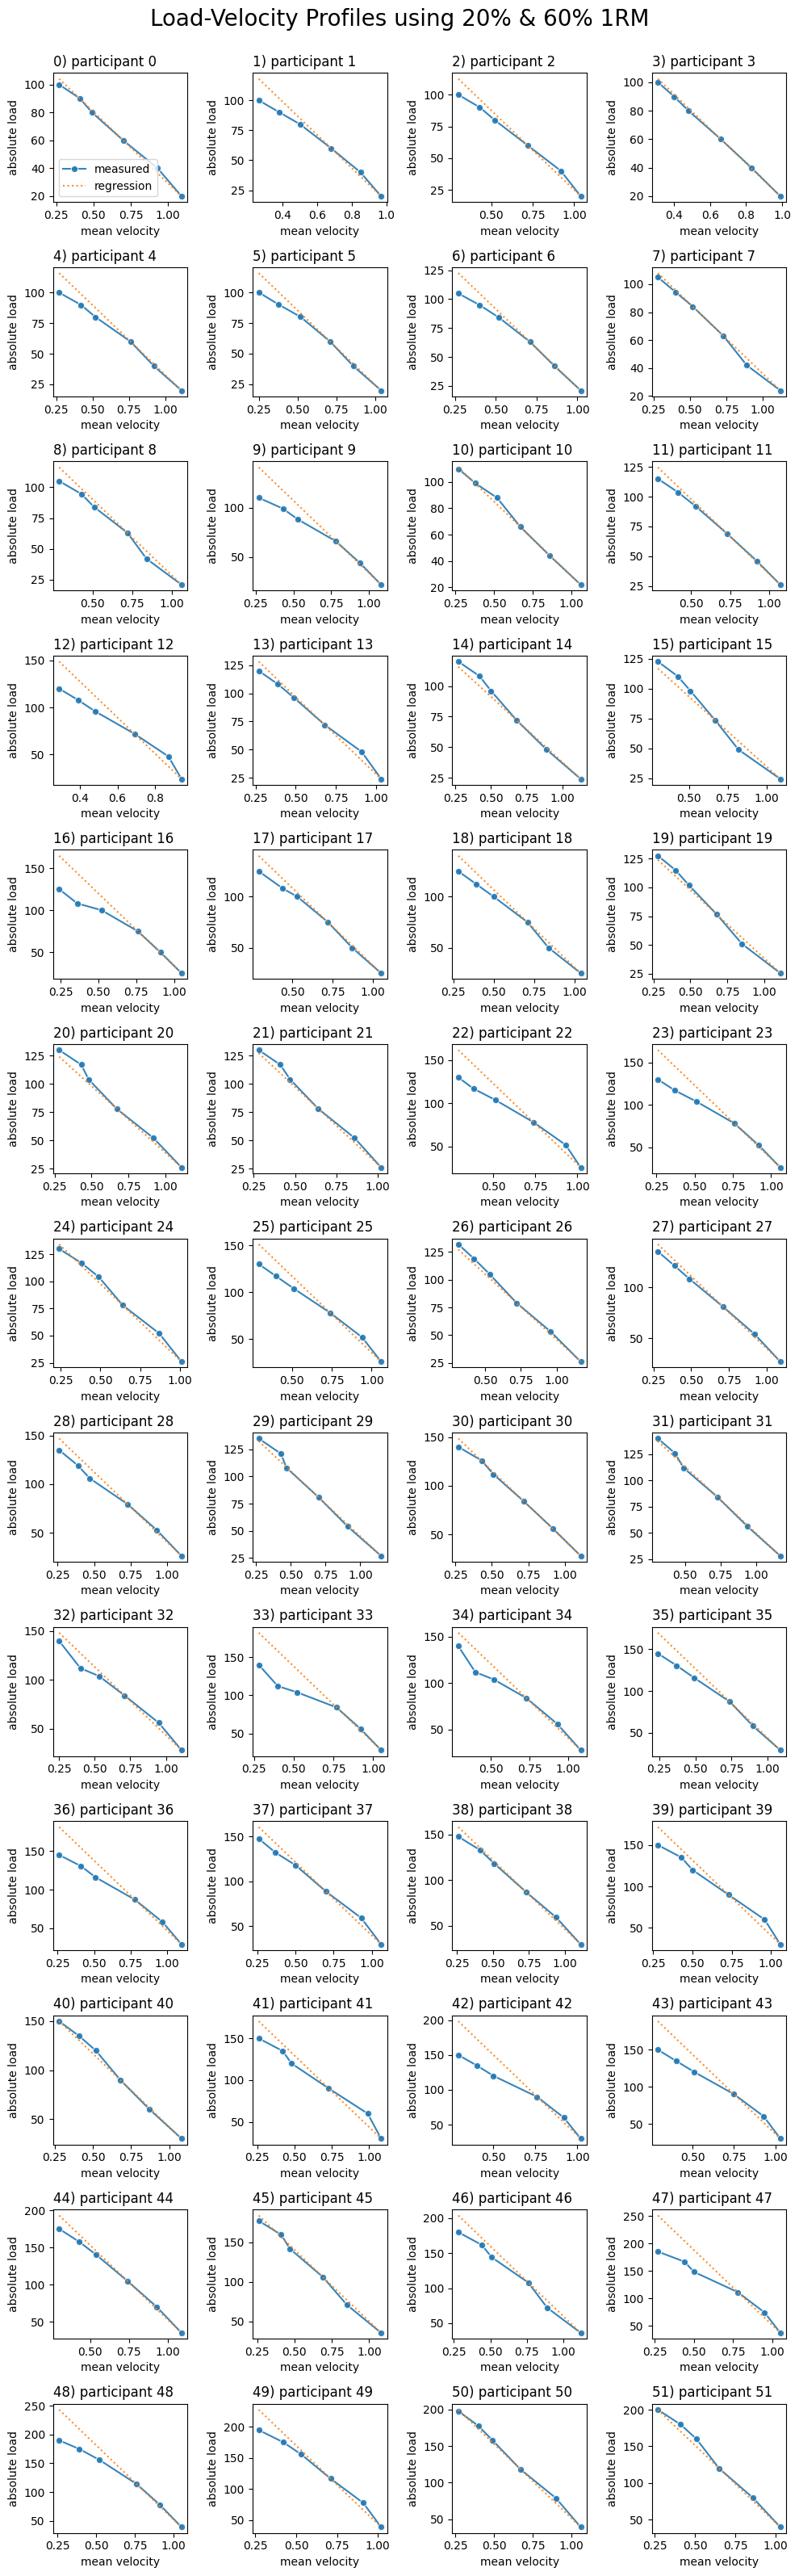

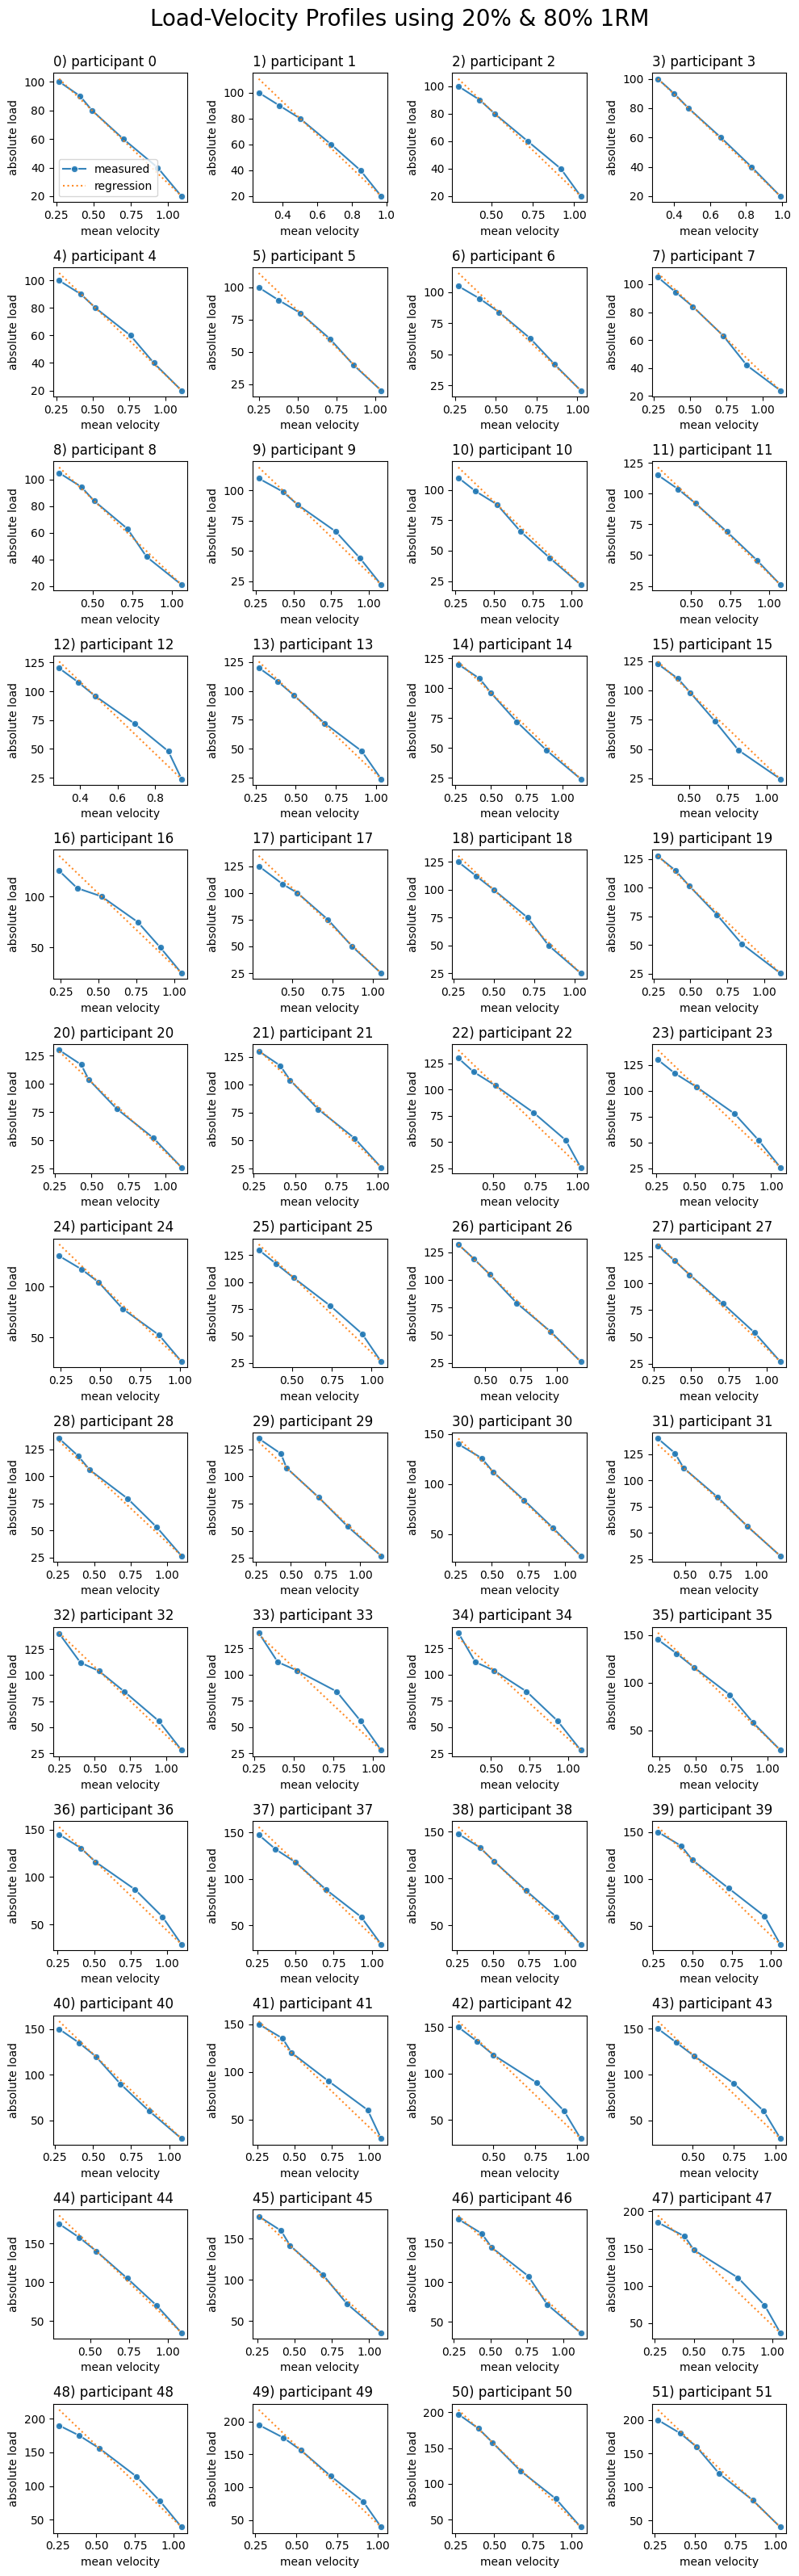

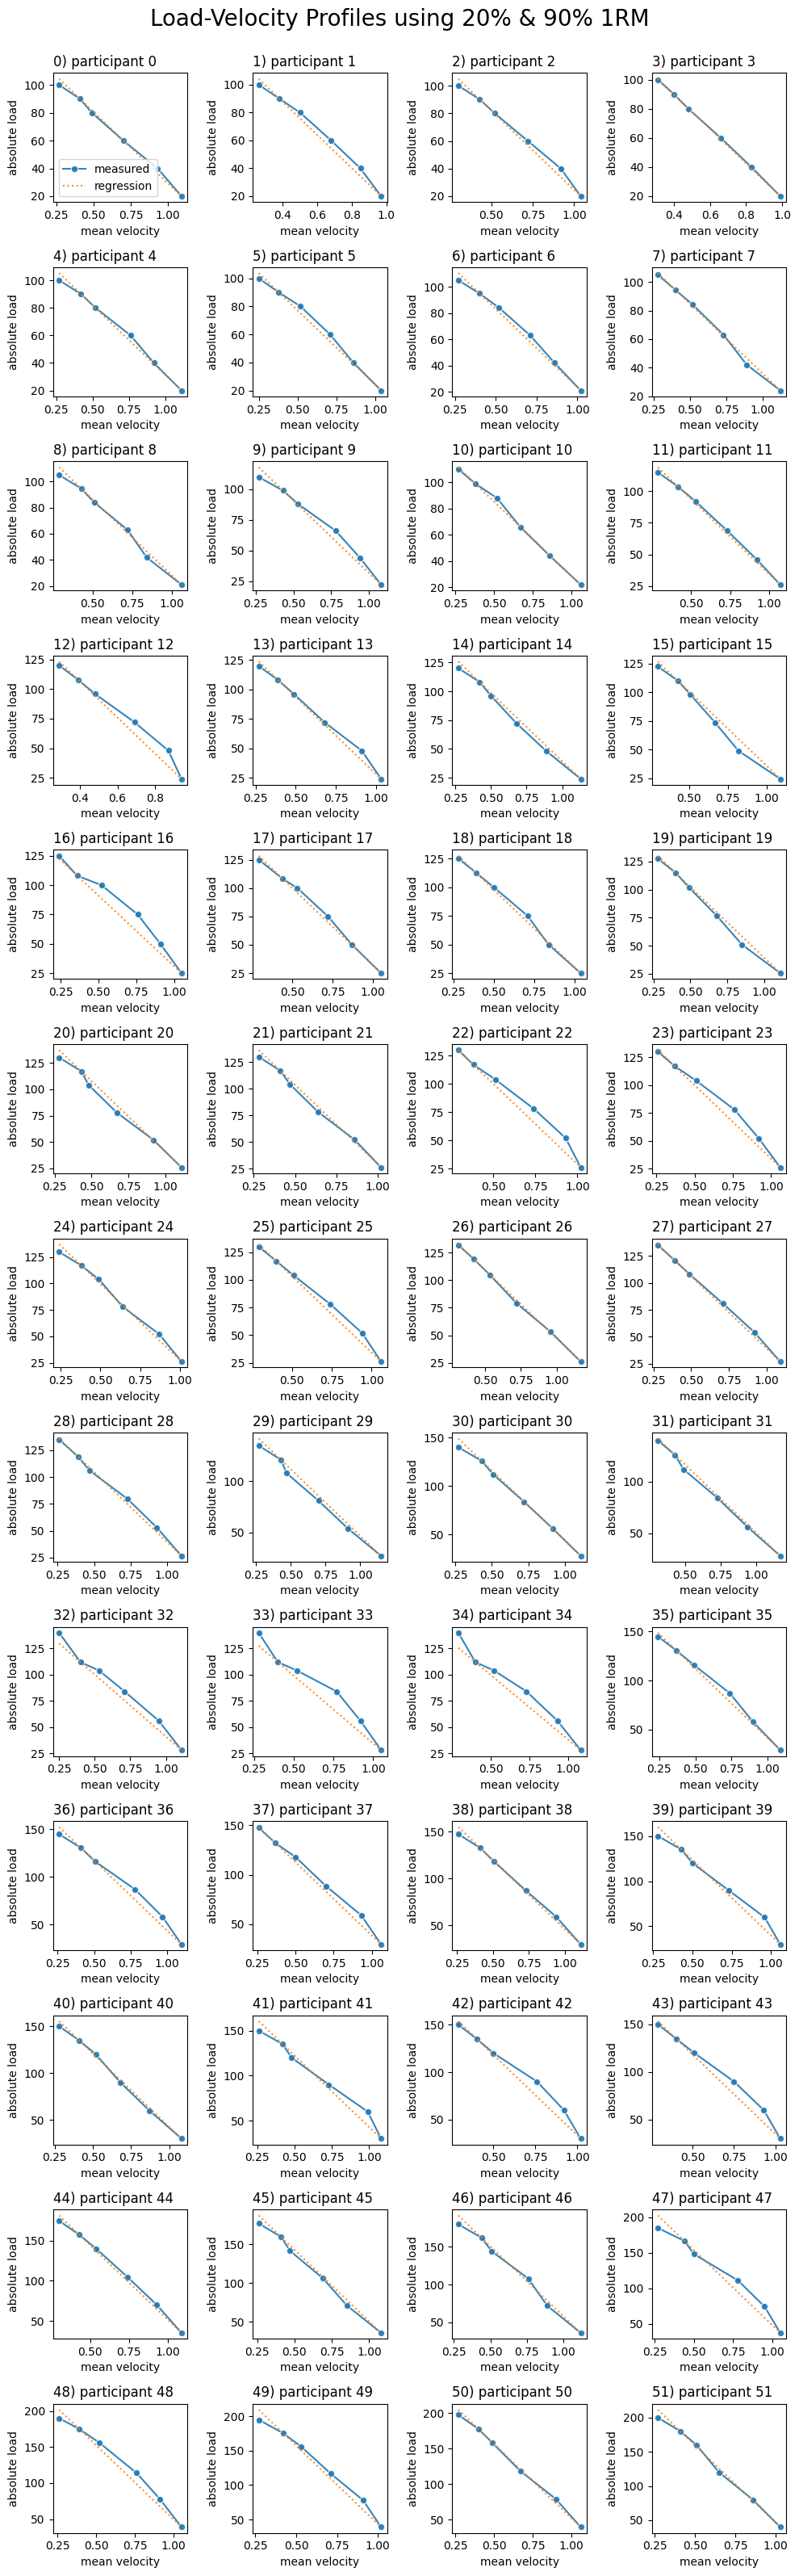

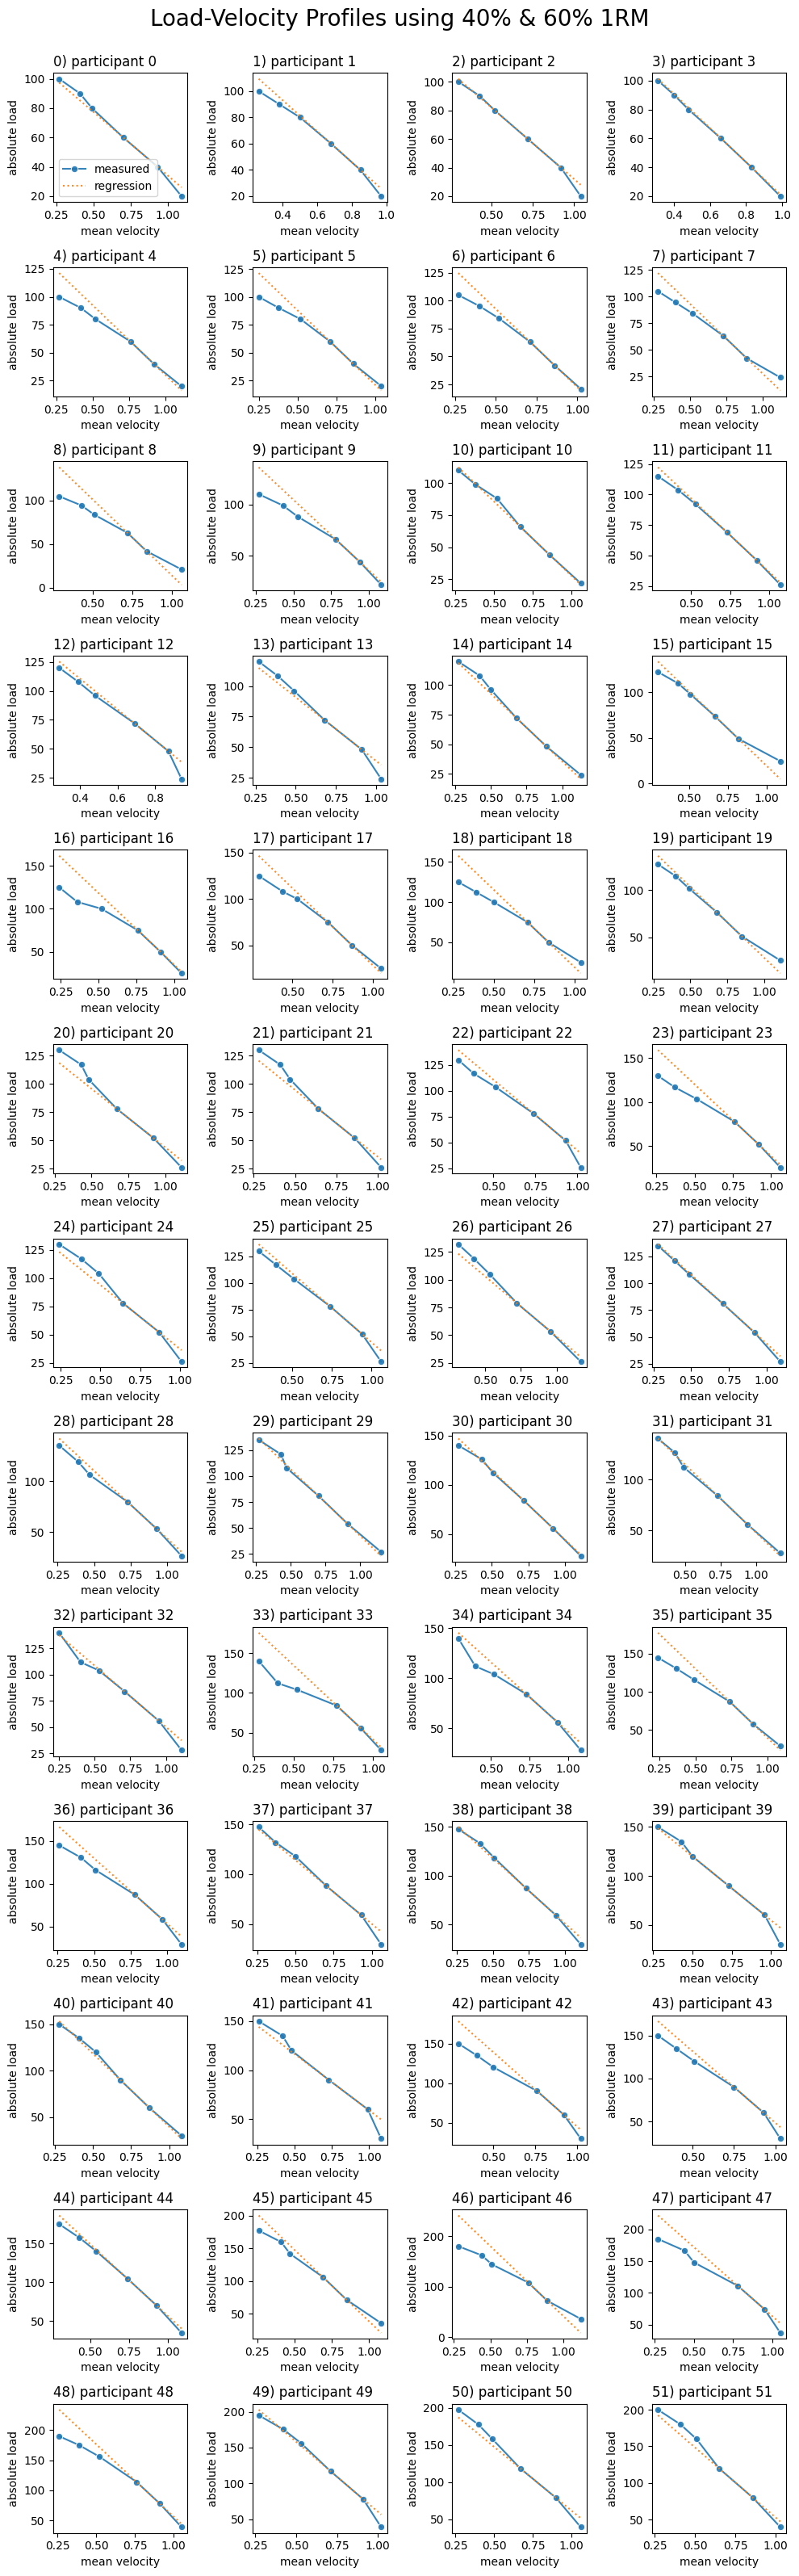

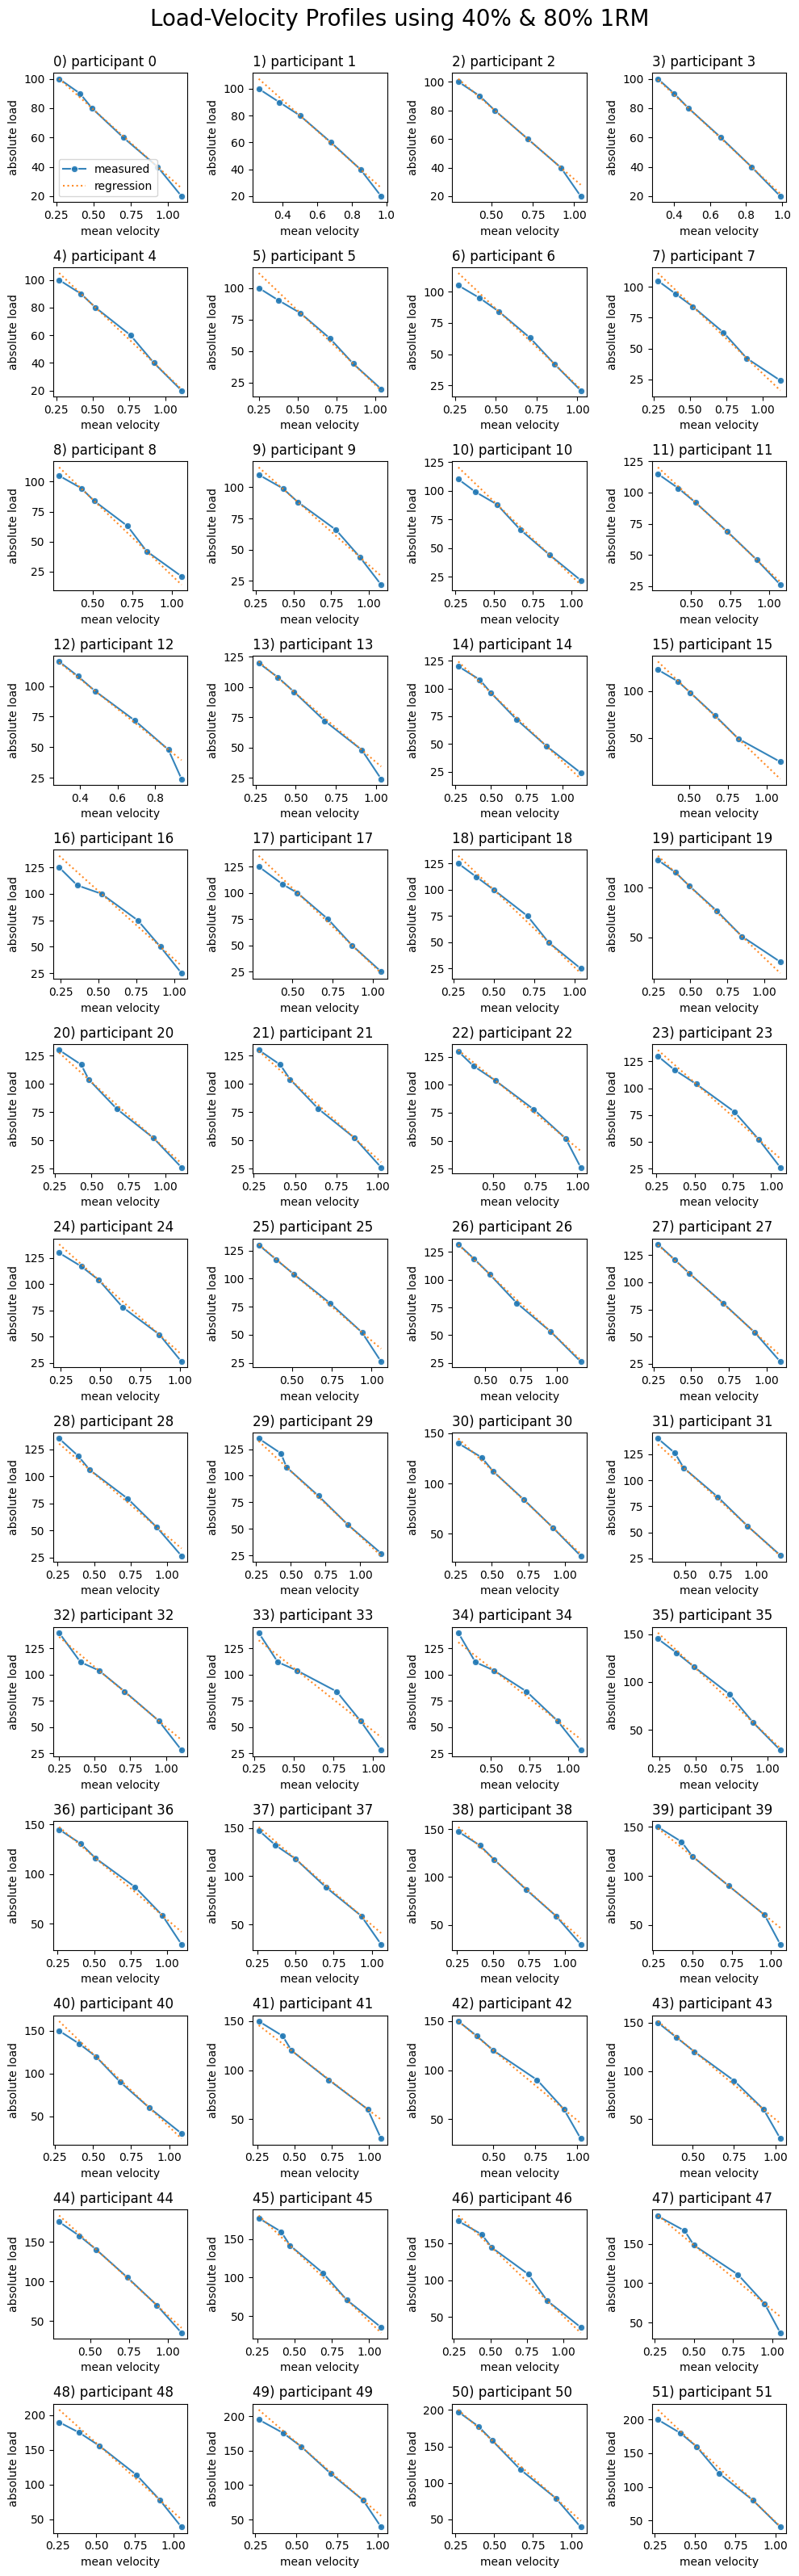

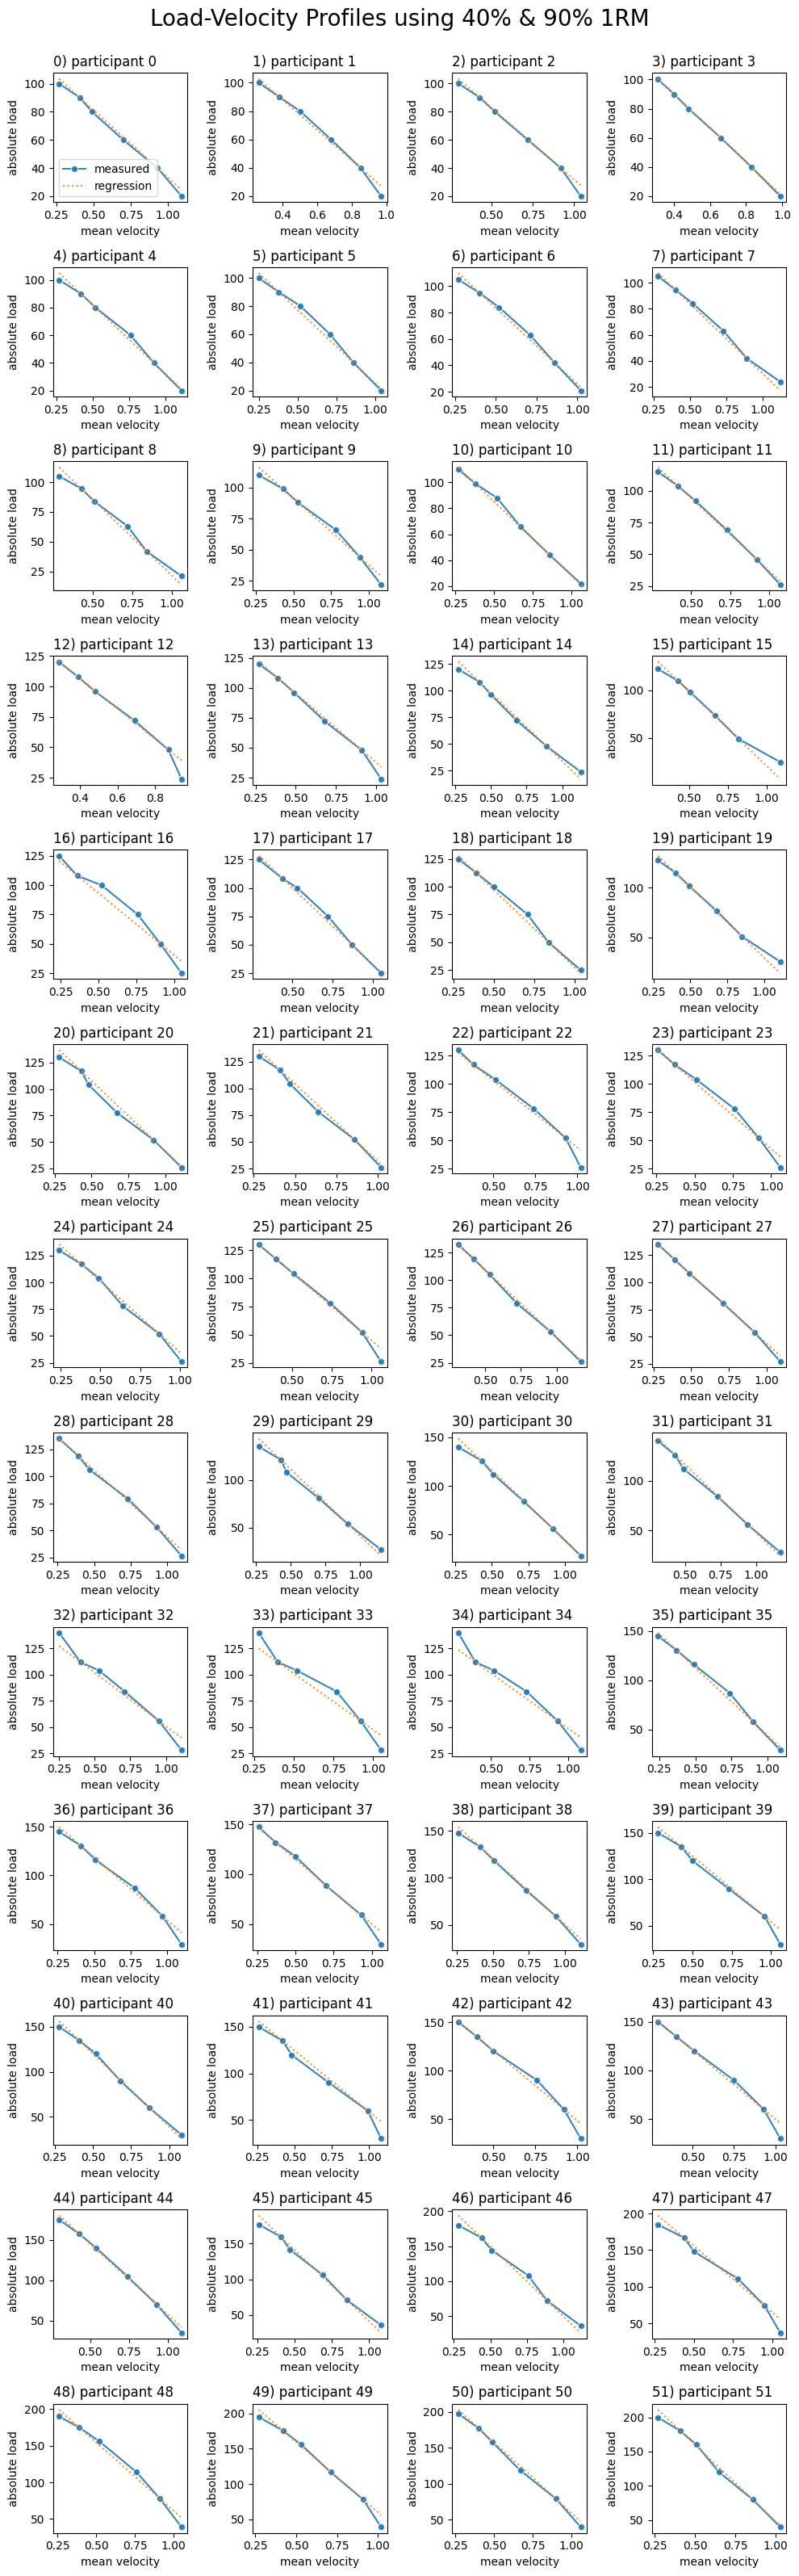

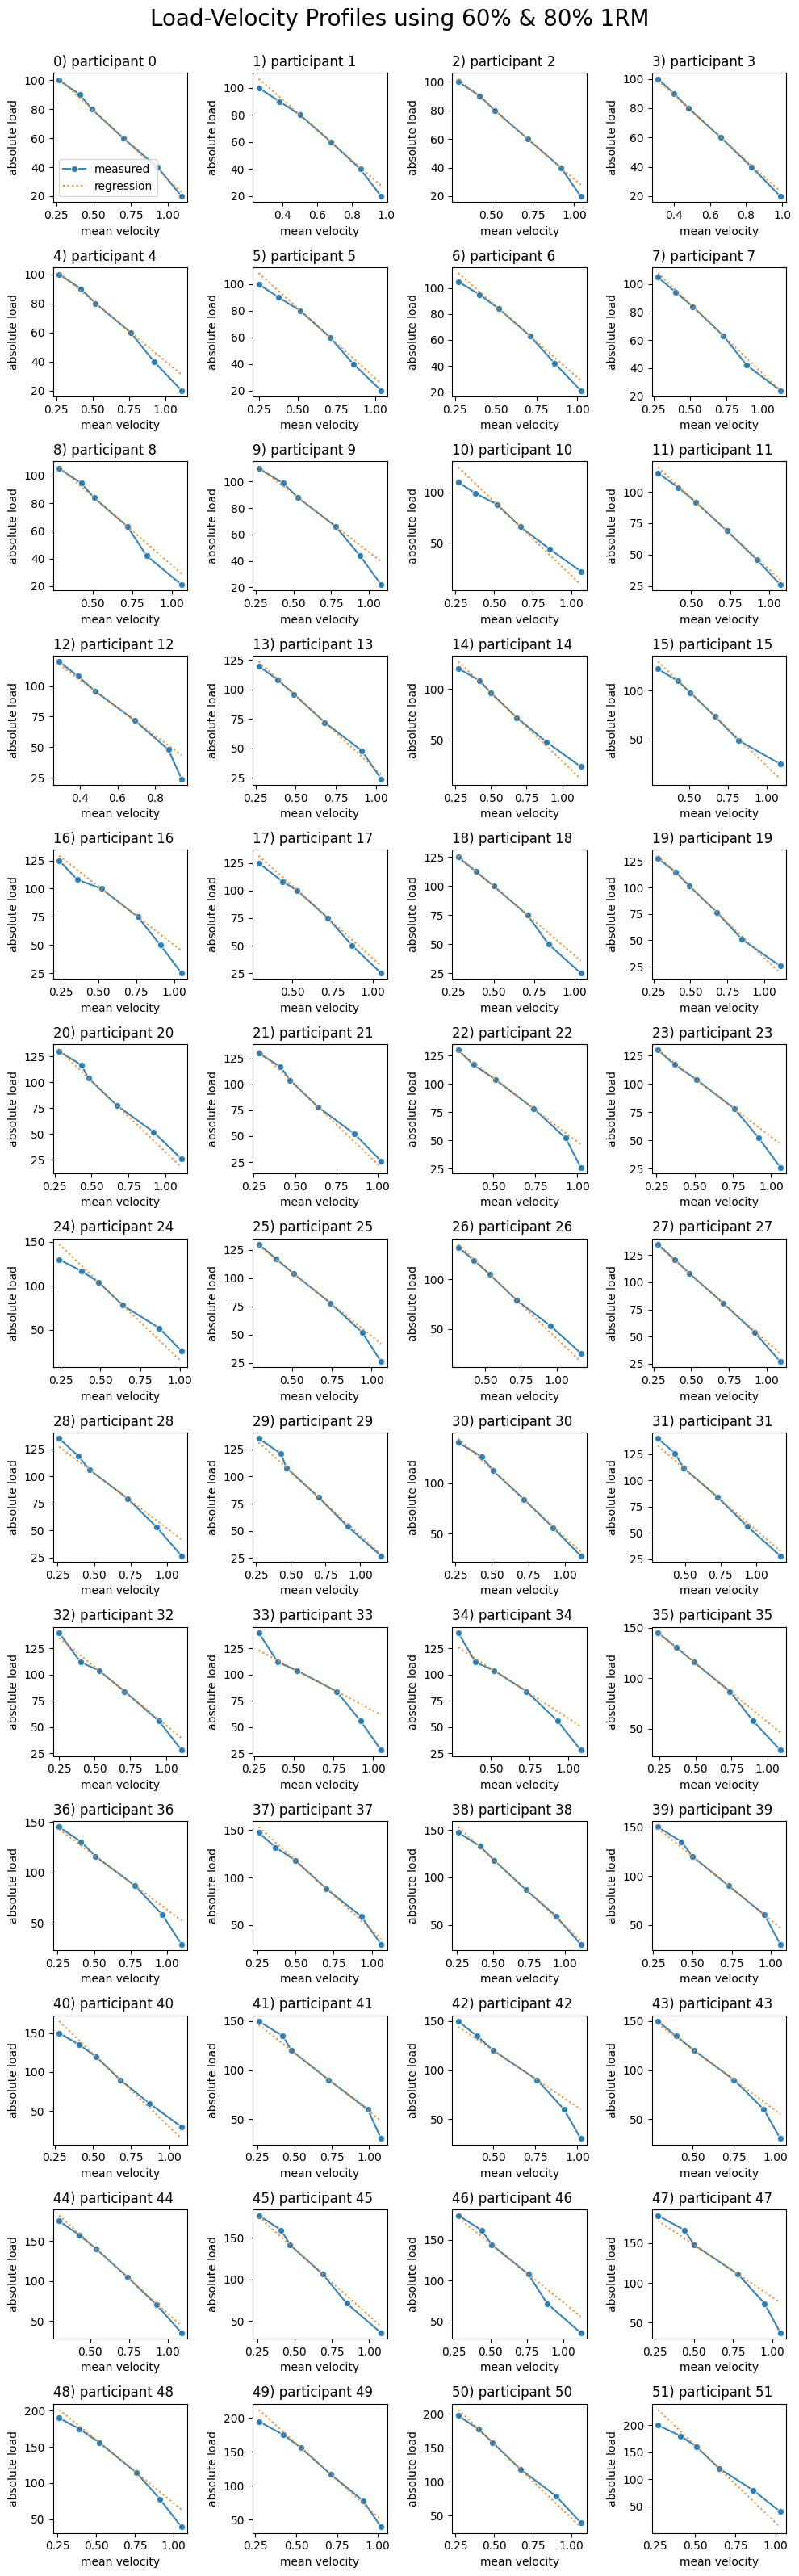

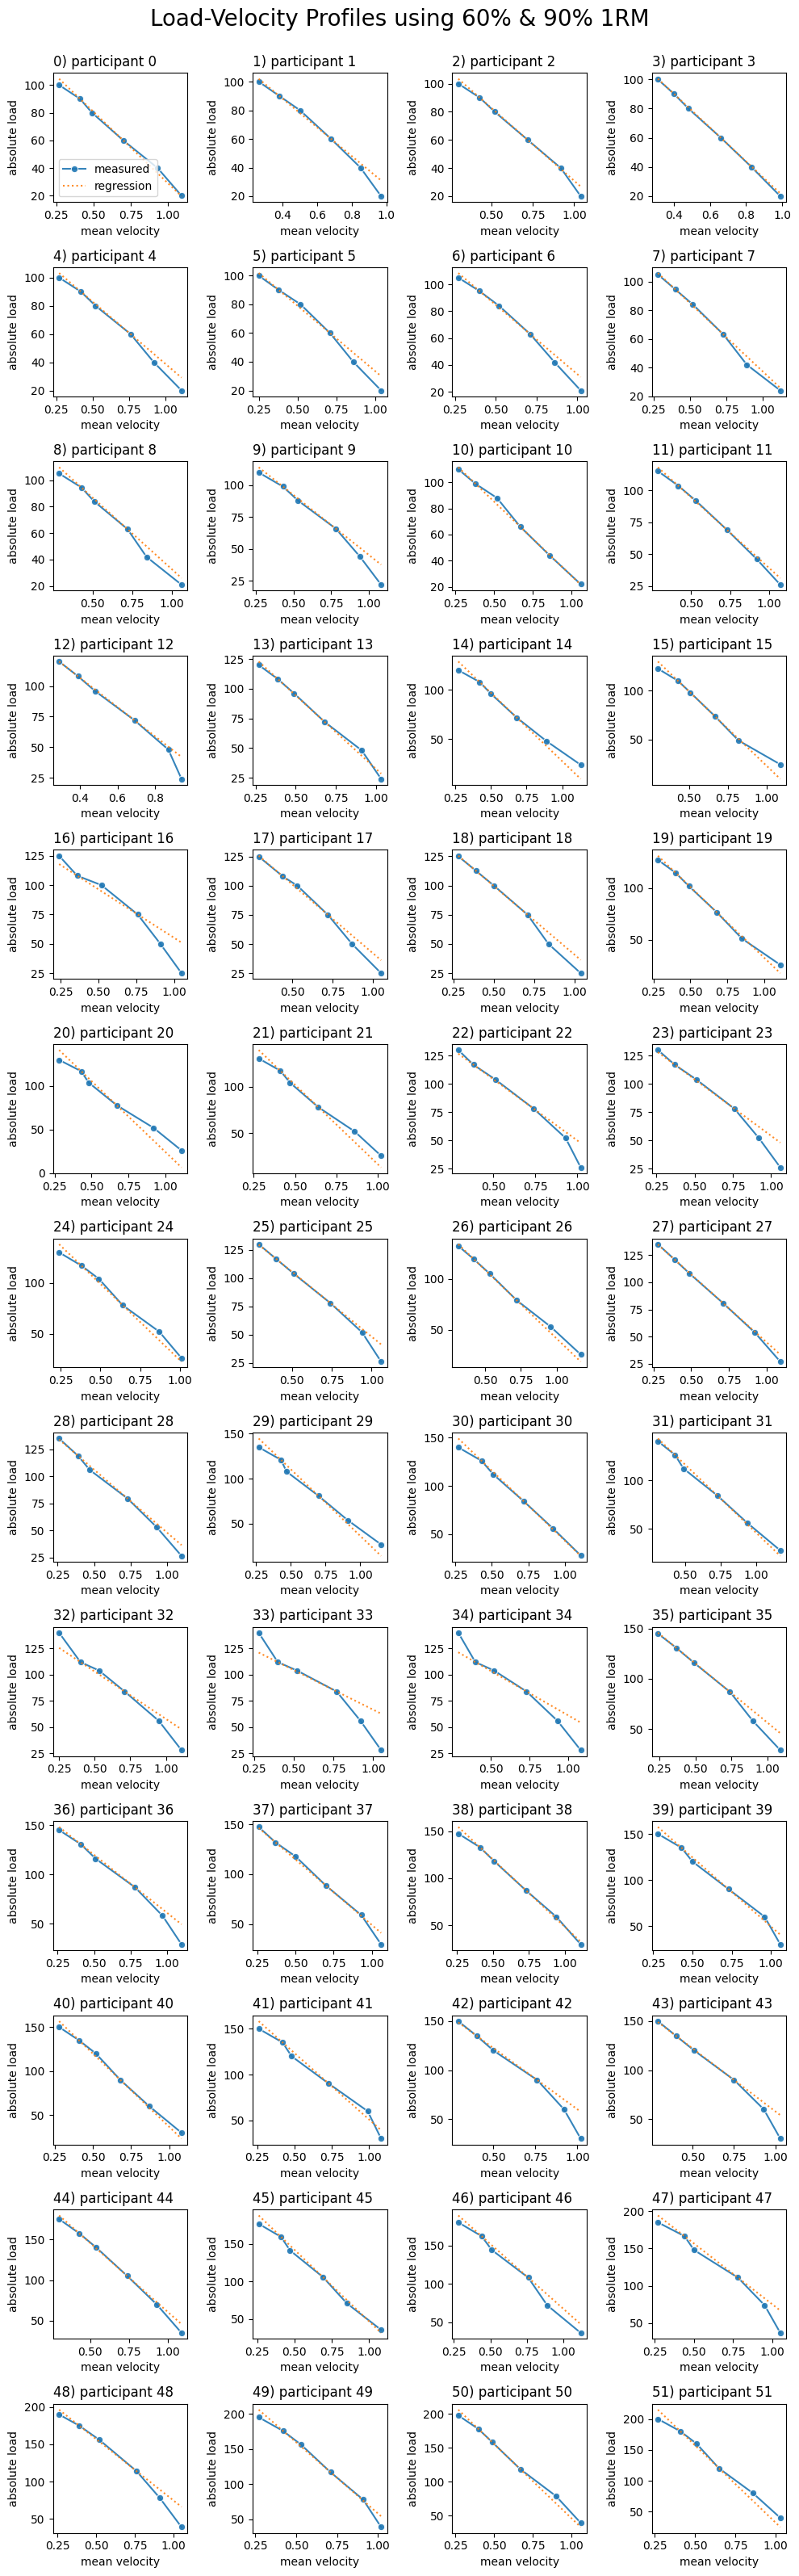

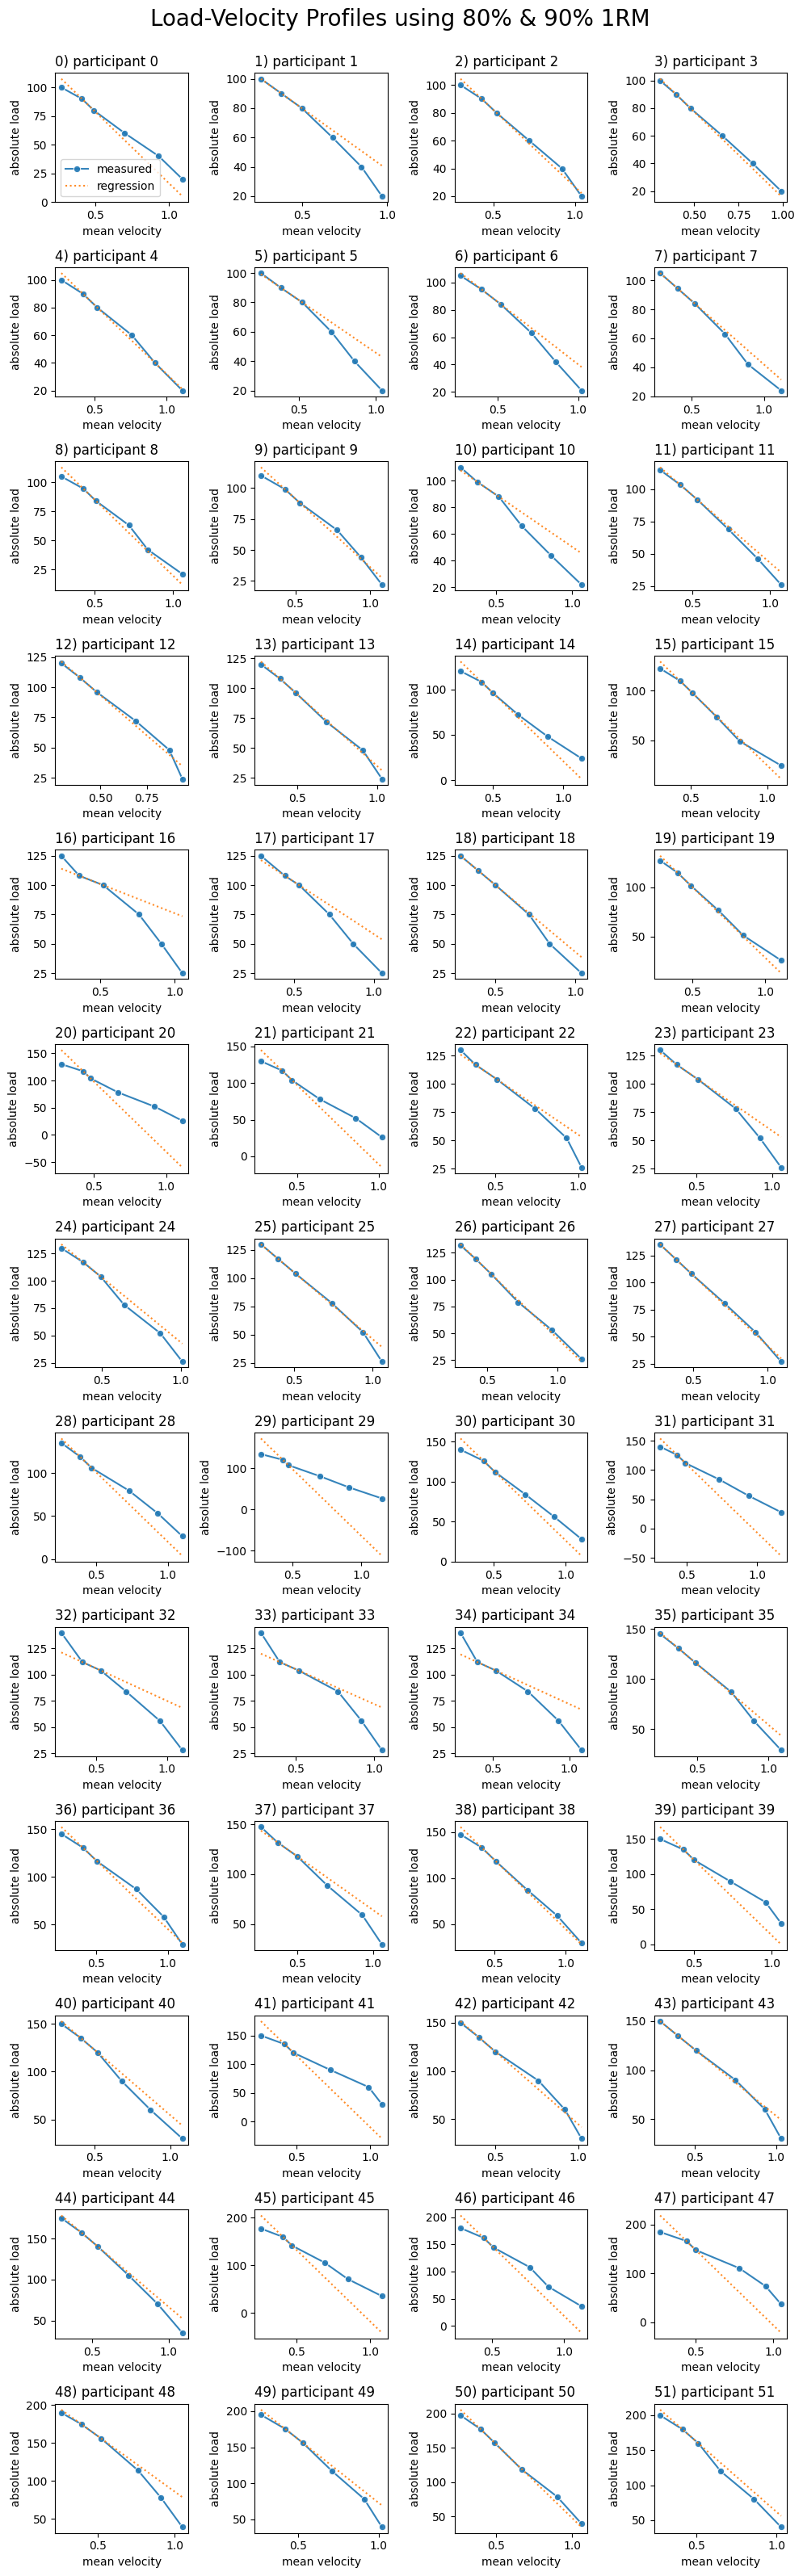

In [28]:
sns.reset_defaults()    
%matplotlib inline
for load_pair in unique_load_pairs:
    plot_profiles_lr(reshape_group_df_lr2(df_fw, load_pair), 
        title=f'Load-Velocity Profiles using {load_pair[0]}% & {load_pair[1]}% 1RM', 
        show_legend=True).savefig(f'../output/figures/EDA figures/FW LV profiles {load_pair[0]} {load_pair[1]} percent RM.png')

## Plot variable distributions and correlations

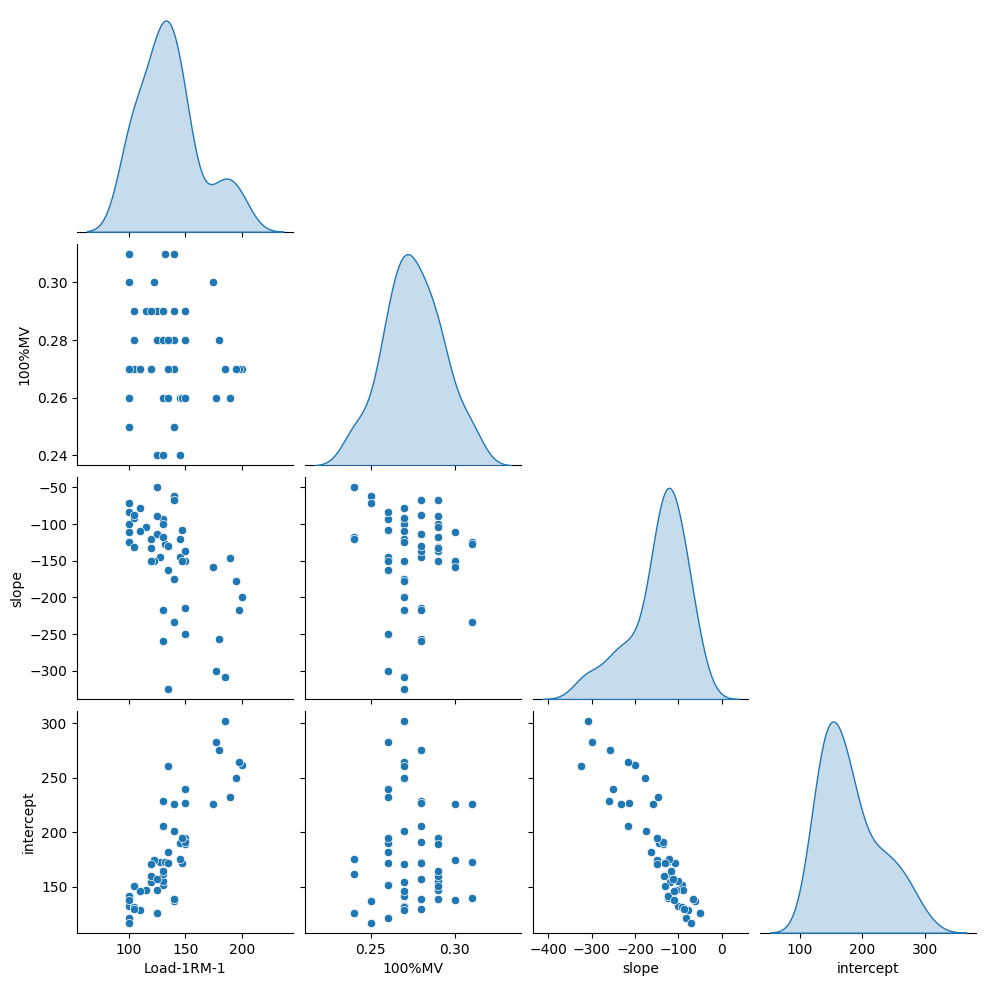

In [30]:
pairplot80_90 = sns.pairplot(df80_90[['Load-1RM-1','100%MV', 'slope', 'intercept']], diag_kind='kde', corner=True)
pairplot80_90.savefig('../output/figures/pairplot_80_90.png')

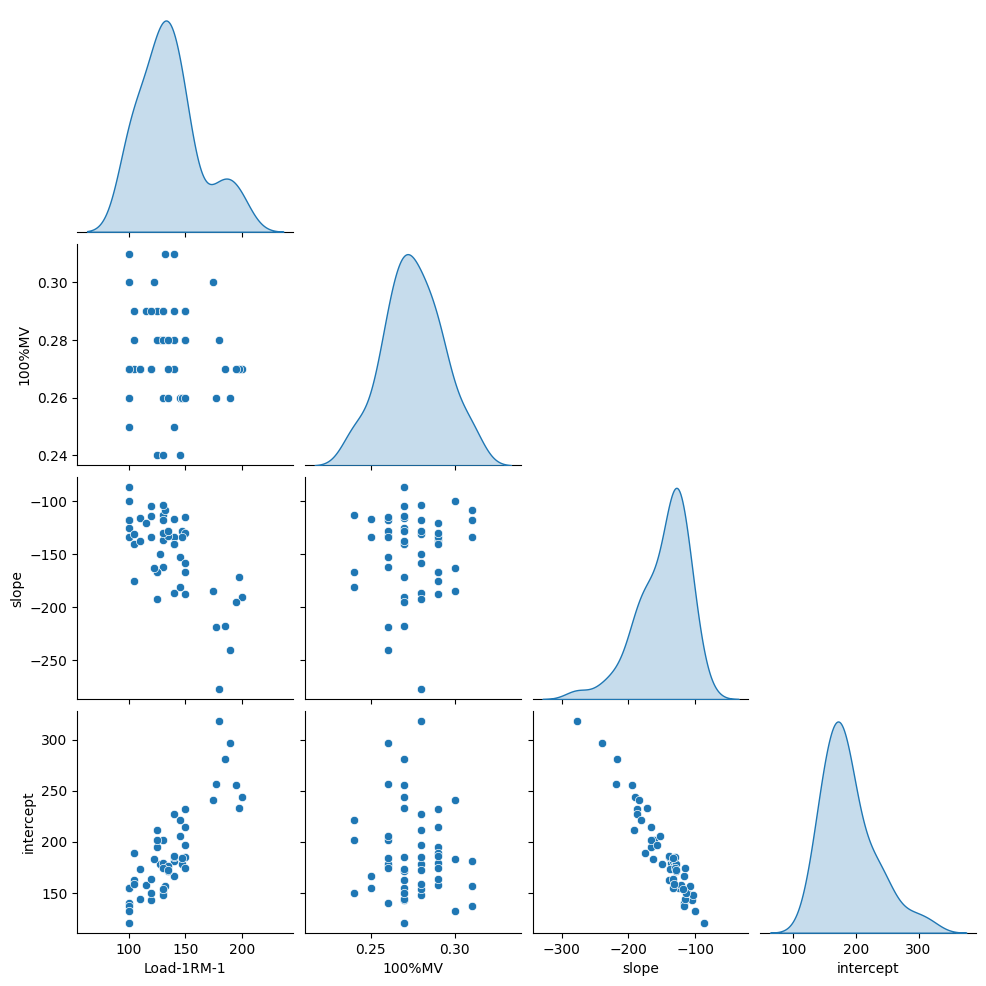

In [31]:
pairplot40_60 = sns.pairplot(df40_60[['Load-1RM-1','100%MV', 'slope', 'intercept']], diag_kind='kde', corner=True)
pairplot40_60.savefig('../output/figures/pairplot_40_60.png')

# Modelling
Only use Model 3, `LinearRegression()`, since it performed just as well as LassoCV

In [10]:
# Initialize dataframes for storing model outputs
predictions = pd.DataFrame()
coefficients = pd.DataFrame()

## 20%


OLS linear Regression: LV profile based 20% & 60% 1RM evaluation metrics: 
		Model of interest	Baseline	Difference
RMSE: 			9.19		22.65		-13.46
MAE: 			6.82		16.96		-10.14
mean error: 		0.00		15.73		-15.73
R^2: 			0.88		0.29		0.60
Pearson r statistic: 	0.94		0.90		0.04
			p=0.00		p=0.00

predictions mean: 	136.28		152.01		-15.73
predictions std: 	25.18		35.59		-10.41

target mean: 136.28
target std: 27.07

Model feature coefficients
	LV slope: 1.1425061876977423
	LV intercept: 1.5131076856096857
	model intercept:  21.08493842477739


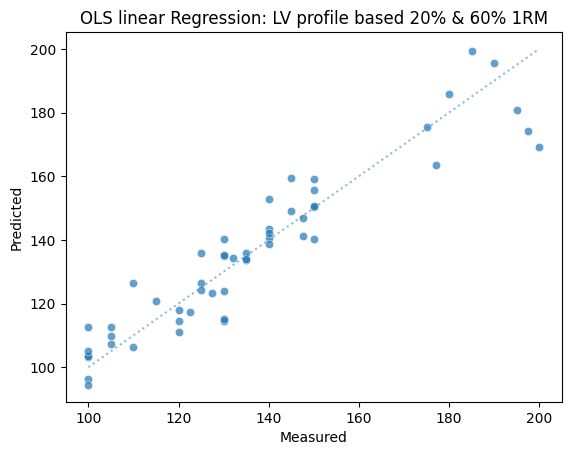

In [34]:
# 20% and 60%
model20_60 = LinearRegression()
predictions['LV 20 60'], eval_fig20_60, coefficients['LV 20 60'] = model_data_vs_stat(df20_60, 
    ['slope', 'intercept'], model20_60, 
    model_name='OLS linear Regression: LV profile based 20% & 60% 1RM')
eval_fig20_60.figure.savefig('../output/figures/individual model figures/02 iteration 20 60.png')


OLS linear Regression: LV profile based 20% & 80% 1RM evaluation metrics: 
		Model of interest	Baseline	Difference
RMSE: 			3.76		8.21		-4.45
MAE: 			3.10		6.54		-3.44
mean error: 		0.00		5.81		-5.81
R^2: 			0.98		0.91		0.07
Pearson r statistic: 	0.99		0.98		0.01
			p=0.00		p=0.00

predictions mean: 	136.28		142.08		-5.81
predictions std: 	26.54		29.49		-2.95

target mean: 136.28
target std: 27.07

Model feature coefficients
	LV slope: 0.6853779171583664
	LV intercept: 1.2708421708447353
	model intercept:  4.516537351067228


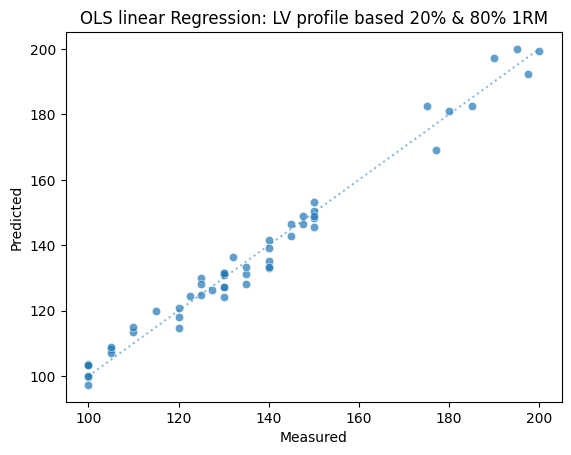

In [24]:
# 20% and 80%
model20_80 = LinearRegression()
predictions['LV 20 80'], eval_fig20_80, coefficients['LV 20 80'] = model_data_vs_stat(df20_80, 
    ['slope', 'intercept'], model20_80, 
    model_name='OLS linear Regression: LV profile based 20% & 80% 1RM')
eval_fig20_80.figure.savefig('../output/figures/individual model figures/02 iteration 20 80.png')


OLS linear Regression: LV profile based 20% & 90% 1RM evaluation metrics: 
		Model of interest	Baseline	Difference
RMSE: 			4.88		7.12		-2.24
MAE: 			3.51		5.83		-2.32
mean error: 		0.00		4.30		-4.30
R^2: 			0.97		0.93		0.04
Pearson r statistic: 	0.98		0.98		-0.00
			p=0.00		p=0.00

predictions mean: 	136.28		140.57		-4.30
predictions std: 	26.36		29.85		-3.49

target mean: 136.28
target std: 27.07

Model feature coefficients
	LV slope: 0.4016230792649719
	LV intercept: 1.0249528989869627
	model intercept:  9.342113811015821


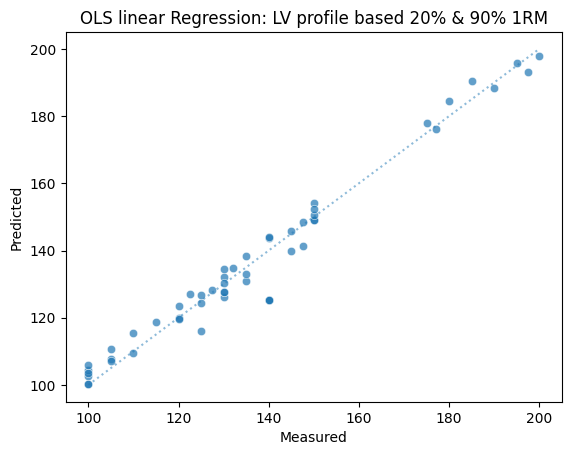

In [30]:
# 20% and 90%
model20_90 = LinearRegression()
predictions['LV 20 90'], eval_fig20_90, coefficients['LV 20 90'] = model_data_vs_stat(df20_90, 
    ['slope', 'intercept'], model20_90, 
    model_name='OLS linear Regression: LV profile based 20% & 90% 1RM')
eval_fig20_90.figure.savefig('../output/figures/individual model figures/02 iteration 20 90.png')

## 40%


OLS linear Regression: LV profile based 40% & 60% 1RM evaluation metrics: 
		Model of interest	Baseline	Difference
RMSE: 			8.52		19.58		-11.07
MAE: 			6.42		14.30		-7.88
mean error: 		-0.00		11.41		-11.41
R^2: 			0.90		0.47		0.43
Pearson r statistic: 	0.95		0.87		0.07
			p=0.00		p=0.00

predictions mean: 	136.28		147.69		-11.41
predictions std: 	25.42		32.95		-7.53

target mean: 136.28
target std: 27.07

Model feature coefficients
	LV slope: 1.1366208728708707
	LV intercept: 1.5123718257941594
	model intercept:  19.935912199010488


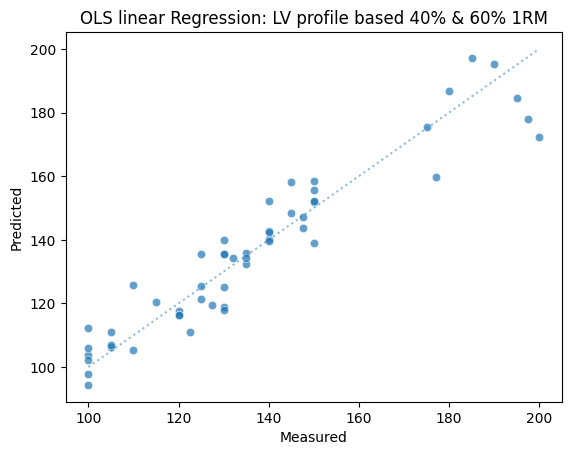

In [16]:
# 40% and 60%
model40_60 = LinearRegression()
predictions['LV 40 60'], eval_fig40_60, coefficients['LV 40 60'] = model_data_vs_stat(df40_60, 
    ['slope', 'intercept'], model40_60, 
    model_name='OLS linear Regression: LV profile based 40% & 60% 1RM')
eval_fig40_60.figure.savefig('../output/figures/individual model figures/02 iteration 40 60.png')


OLS linear Regression: LV profile based 40% & 80% 1RM evaluation metrics: 
		Model of interest	Baseline	Difference
RMSE: 			3.57		6.84		-3.27
MAE: 			2.87		5.42		-2.55
mean error: 		-0.00		3.74		-3.74
R^2: 			0.98		0.93		0.05
Pearson r statistic: 	0.99		0.98		0.01
			p=0.00		p=0.00

predictions mean: 	136.28		140.02		-3.74
predictions std: 	26.57		28.47		-1.90

target mean: 136.28
target std: 27.07

Model feature coefficients
	LV slope: 0.7260914233646235
	LV intercept: 1.2983807940892964
	model intercept:  4.7928887027669305


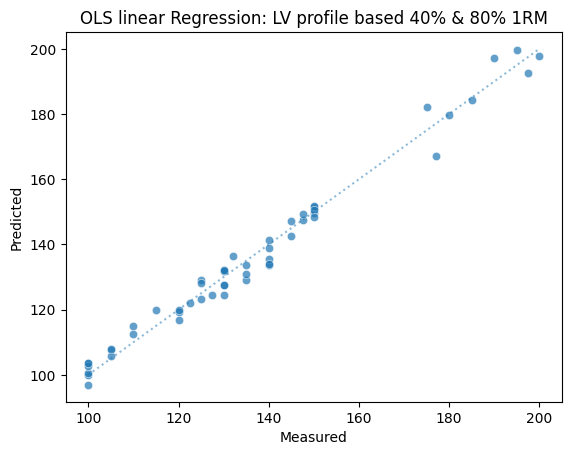

In [18]:
# 40% and 80%
model40_80 = LinearRegression()
predictions['LV 40 80'], eval_fig40_80, coefficients['LV 40 80'] = model_data_vs_stat(df40_80, 
    ['slope', 'intercept'], model40_80, 
    model_name='OLS linear Regression: LV profile based 40% & 80% 1RM')
eval_fig40_80.figure.savefig('../output/figures/individual model figures/02 iteration 40 80.png')

## 60%


OLS linear Regression: LV profile based 60% & 80% 1RM evaluation metrics: 
		Model of interest	Baseline	Difference
RMSE: 			3.63		8.03		-4.40
MAE: 			2.96		5.74		-2.78
mean error: 		-0.00		2.38		-2.38
R^2: 			0.98		0.91		0.07
Pearson r statistic: 	0.99		0.97		0.03
			p=0.00		p=0.00

predictions mean: 	136.28		138.66		-2.38
predictions std: 	26.56		29.34		-2.78

target mean: 136.28
target std: 27.07

Model feature coefficients
	LV slope: 0.6497926613840683
	LV intercept: 1.2420434560360352
	model intercept:  4.325033472690478


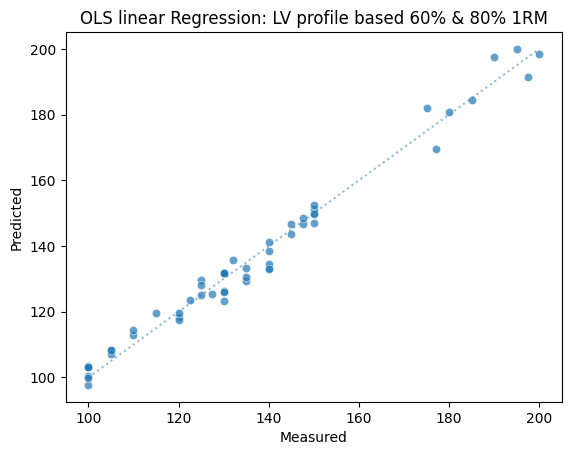

In [25]:
# 60% and 80%
model60_80 = LinearRegression()
predictions['LV 60 80'], eval_fig60_80, coefficients['LV 60 80'] = model_data_vs_stat(df60_80, 
    ['slope', 'intercept'], model60_80, 
    model_name='OLS linear Regression: LV profile based 60% & 80% 1RM')
eval_fig60_80.figure.savefig('../output/figures/individual model figures/02 iteration 60 80.png')


OLS linear Regression: LV profile based 60% & 90% 1RM evaluation metrics: 
		Model of interest	Baseline	Difference
RMSE: 			4.15		7.22		-3.07
MAE: 			3.20		5.49		-2.30
mean error: 		0.00		2.84		-2.84
R^2: 			0.98		0.93		0.05
Pearson r statistic: 	0.99		0.98		0.01
			p=0.00		p=0.00

predictions mean: 	136.28		139.12		-2.84
predictions std: 	26.48		29.71		-3.23

target mean: 136.28
target std: 27.07

Model feature coefficients
	LV slope: 0.5898375891019637
	LV intercept: 1.1790817070105613
	model intercept:  7.111525950849369


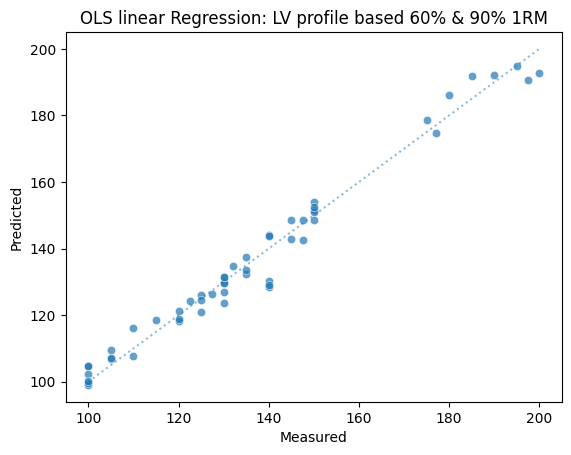

In [35]:
# 60% and 90%
model60_90 = LinearRegression()
predictions['LV 60 90'], eval_fig60_90, coefficients['LV 60 90'] = model_data_vs_stat(df60_90, 
    ['slope', 'intercept'], model60_90, 
    model_name='OLS linear Regression: LV profile based 60% & 90% 1RM')
eval_fig60_90.figure.savefig('../output/figures/individual model figures/02 iteration 60 90.png')


OLS linear Regression: LV profile based 80% & 90% 1RM evaluation metrics: 
		Model of interest	Baseline	Difference
RMSE: 			3.82		12.59		-8.77
MAE: 			2.87		8.56		-5.70
mean error: 		-0.00		5.19		-5.19
R^2: 			0.98		0.78		0.20
Pearson r statistic: 	0.99		0.94		0.05
			p=0.00		p=0.00

predictions mean: 	136.28		141.47		-5.19
predictions std: 	26.53		32.35		-5.82

target mean: 136.28
target std: 27.07

Model feature coefficients
	LV slope: 0.5347213259385835
	LV intercept: 1.14874911152286
	model intercept:  5.622936479932406


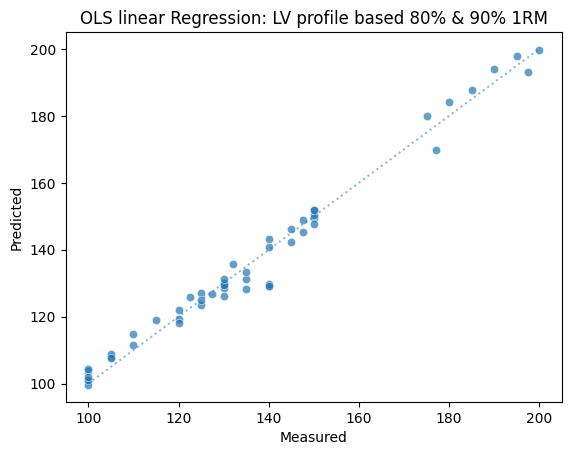

In [12]:
# 80% and 90% 1RM
model80_90 = LinearRegression()
predictions['LV 80 90'], eval_fig80_90, coefficients['LV 80 90'] = model_data_vs_stat(df80_90, ['slope', 'intercept'], model80_90, 
    model_name='OLS linear Regression: LV profile based 80% & 90% 1RM')
eval_fig80_90.figure.savefig('../output/figures/individual model figures/02 iteration 80-90.png')

# Compile results

In [36]:
predictions = predictions.sort_index(axis=1)
predictions.head()

LV 20 60    LV 20 80    LV 20 90    LV 40 60    LV 40 80    LV 60 80  \
0  195.507401  197.350598  188.319118  195.413912  197.153610  197.396051   
1  114.450228  118.162019  119.788774  117.535411  119.164892  118.358085   
2  140.399651  131.401621  126.308652  139.977943  131.717917  131.797101   
3   96.203405   99.806443  100.147420   97.947865   99.874664  100.491740   
4  158.985166  148.371223  149.126237  158.445948  149.612723  150.050525   

     LV 60 90    LV 80 90  
0  192.019097  193.981152  
1  118.314950  119.282740  
2  129.706350  129.841625  
3   99.050226  100.827301  
4  151.511943  149.420814

In [40]:
coefficients = coefficients.sort_index(axis=1)
coefficients

LV 20 60  LV 20 80  LV 20 90   LV 40 60  LV 40 80  LV 60 80  \
LV slope          1.142506  0.685378  0.401623   1.136621  0.726091  0.649793   
LV intercept      1.513108  1.270842  1.024953   1.512372  1.298381  1.242043   
model intercept  21.084938  4.516537  9.342114  19.935912  4.792889  4.325033   

                 LV 60 90  LV 80 90  
LV slope         0.589838  0.534721  
LV intercept     1.179082  1.148749  
model intercept  7.111526  5.622936

In [39]:
# save predictions and coefficients
save_csv(predictions, '02 iteration predictions', path=r'../output/predictions/')
save_csv(coefficients, '02 iteration coeffficients', path=r'../output/predictions/')

File saved:  ../output/predictions//02 iteration predictions.csv
File saved:  ../output/predictions//02 iteration coeffficients.csv


# Plot results

Metrics dataframe shape (free weight data): (416, 3)
Metrics dataframe shape (Smith machine data): (416, 3)
File saved:  ../output/predictions/free weight errors
File saved:  ../output/predictions/smith machine errors


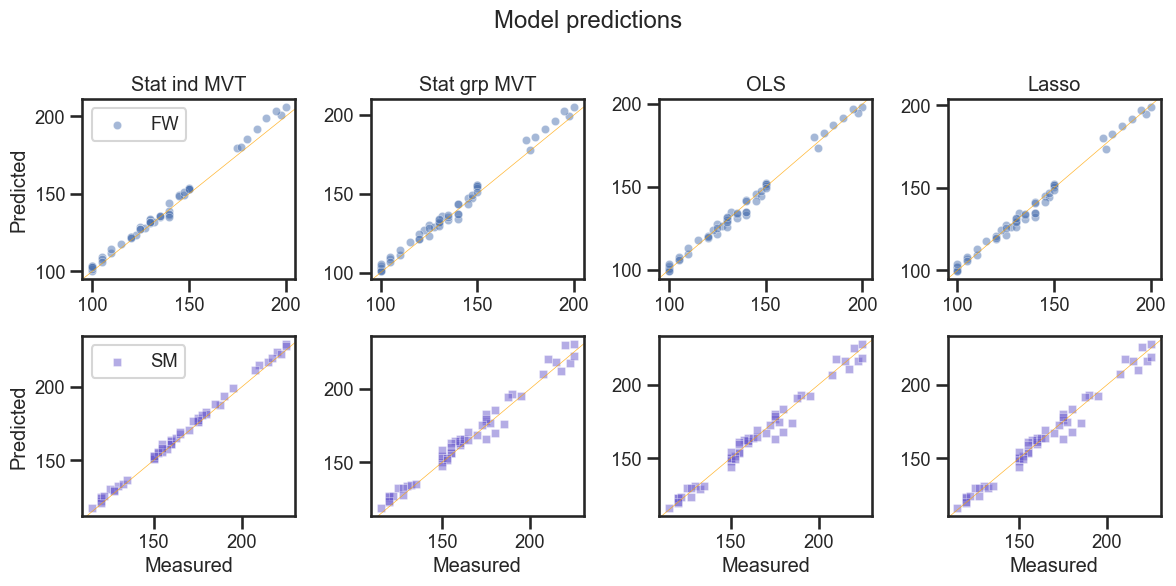

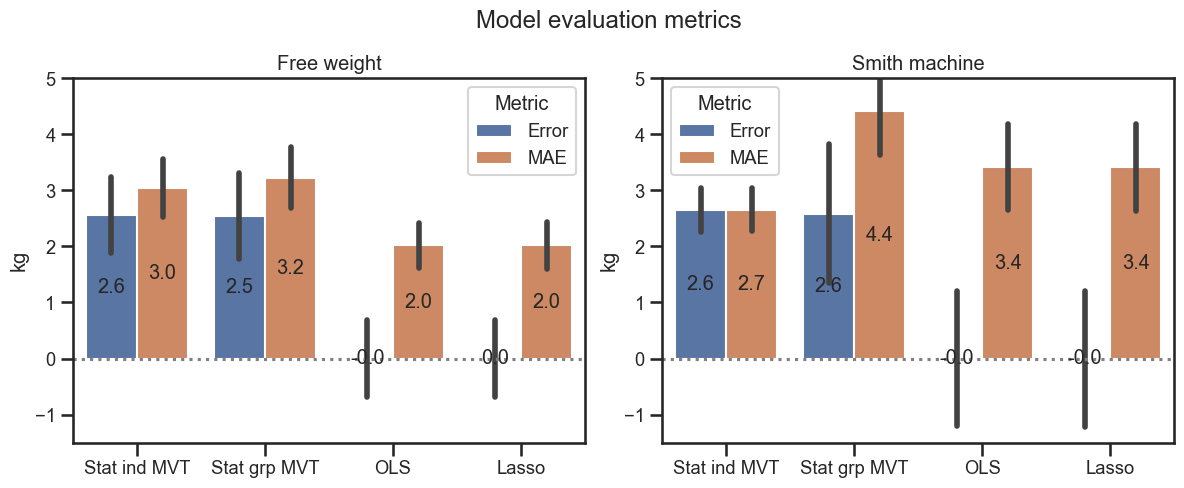

In [1191]:
import matplotlib.pyplot as plt
def compare_models(fw_predictions, sm_predictions, title='Model predictions', 
    context='talk', annotate=True, ymin=-1.5, ymax=5):
    """

    Plot predictions from all the models for each of the free weight and smith machine data sets.
        Parameters:
            - fw_predictions, sm_predictions (DataFrame): 
                Dataframes that each contain target data ('Measured' column) and model predictions
                (1 column per model).
            - title (str): Overall plot title.
            - context (None or str): Seaborn .set_theme() parameter. 
                One of {paper, notebook, talk (default), poster}. If None, set to 'default (notebook)'.
            - annotate (bool): Whether or not to annotate the bar graph with values. Default is True.
        Returns:
            - figure with scatter plots of measured vs. predicted values for all models.
            - figure with bar charts of mean absolute error and mean error for all models.
            - DataFrames for each of the free weight and smith machine data sets containing:
                mean absolute error and mean error for all models.

    Command syntax:
        scatterplot, error_plot, fw_metrics, sm_metrics = compare_models(fw_predictions, 
        sm_predictions, title='Model predictions', context='talk')

        scatterplot.savefig('../output/figures/Measured vs predicted for all samples.png')
        error_plot.savefig('../output/figures/Error bar chart for all samples.png')
        path = r'../output/predictions'
        save_csv(fw_metrics, 'free weight errors', path=path)
        save_csv(sm_metrics, 'smith machine errors', path=path)
    """
    fw_models = fw_predictions.columns[1:].to_list()
    sns.reset_defaults()    
    %matplotlib inline
    font_scale=.8 if context=='talk' else 1
    rc={'lines.markersize': 6} if context=='talk' else None
    sns.set_theme(context=context, style='ticks', font_scale=font_scale, 
        rc=rc)
    ncols = len(fw_models)
    fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(3*ncols, 2*3))
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(3*ncols, 5))
    fw_error = pd.DataFrame()
    sm_error = pd.DataFrame()
    for index, model in enumerate(fw_models):
        # Calculate error
        fw_error[model] = fw_predictions[model] - fw_predictions['Measured'] 
        sm_error[model] = sm_predictions[model] - sm_predictions['Measured'] 

        # Plot measured vs. predicted values for each model
        ax[0, index].axline(xy1=(150, 150), slope=1, alpha=0.8, linewidth=0.5, color='orange')
        if index == 0:
            ax[0, index].set_ylabel('Predicted') 
        sns.scatterplot(data=fw_predictions, x='Measured', y=model, ax=ax[0, index],
            alpha=0.5, marker='o', legend=(True if index==0 else False), label='FW',
        ).set(xlabel=None, ylabel=None)
        ax[0, index].set_title(model)
        if index == 0:
            ax[0, index].set_ylabel('Predicted') 

        ax[1, index].axline(xy1=(150, 150), slope=1, alpha=0.8, linewidth=0.5, color='orange')
        sns.scatterplot(data=sm_predictions, x='Measured', y=model, ax=ax[1, index],
            alpha=0.5, marker='s', legend=(True if index==0 else False), 
            label='SM', color='slateblue',
        ).set(ylabel=None)
        if index == 0:
            ax[1, index].set_ylabel('Predicted')   
        
    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    fig2.tight_layout(rect=[0, 0, 1, 0.9])

    # Calculate remaining evaluation metrics and reshape dataframe for plotting
    fw_error['Metric'] = 'Error'
    fw_mae = abs(fw_error.iloc[:,:-1])
    fw_mae['Metric'] = 'MAE'
    fw_metrics = pd.concat([fw_error, fw_mae], axis=0).melt(
        value_vars=fw_models, id_vars=['Metric'], var_name='model')
    print(f'Metrics dataframe shape (free weight data): {fw_metrics.shape}')

    sm_error['Metric'] = 'Error'
    sm_mae = abs(sm_error.iloc[:,:-1])
    sm_mae['Metric'] = 'MAE'
    sm_metrics = pd.concat([sm_error, sm_mae], axis=0).melt(
        value_vars=fw_models, id_vars=['Metric'], var_name='model')
    print(f'Metrics dataframe shape (Smith machine data): {sm_metrics.shape}')
    
    # Plot evaluation metrics: 
    sns.barplot(data=fw_metrics, y='value', x='model', hue='Metric', 
        errorbar=('se', 1.96), # error bars set to 95% confidence interval, or 1.96*standard error
        ax=ax2[0]).set_ylim([ymin, ymax])
    ax2[0].axhline(y=0, ls=':', color='grey')
    ax2[0].set(ylabel='kg', xlabel=None)
    ax2[0].set_title('Free weight')
    sns.barplot(data=sm_metrics, y='value', x='model', hue='Metric', 
        errorbar=('se', 1.96),
        ax=ax2[1]).set_ylim([ymin, ymax])    
    ax2[1].axhline(y=0, ls=':', color='grey')

    # Label bars with value
    if annotate:
        for i in ax2[0].containers:
                ax2[0].bar_label(i, fmt='%.1f', label_type='center') 
        for i in ax2[1].containers:
                ax2[1].bar_label(i, fmt='%.1f', label_type='center') 
    # Titles and axis labels
    ax2[1].set(ylabel='kg', xlabel=None)
    ax2[0].set_title('Free weight')
    ax2[1].set_title('Smith machine')
    fig2.suptitle('Model evaluation metrics')
    return fig, fig2, fw_metrics, sm_metrics

scatterplot, error_plot, fw_metrics, sm_metrics = compare_models(fw_predictions, 
    sm_predictions, title='Model predictions', context='talk')

# scatterplot.savefig('../output/figures/Measured vs predicted for all samples.png')
# error_plot.savefig('../output/figures/Error bar chart for all samples.png')
# path = r'../output/predictions'
# save_csv(fw_metrics, 'free weight errors', path=path)
# save_csv(sm_metrics, 'smith machine errors', path=path)

In [1178]:
fw_metrics

Metric         model     value
0    Error  Stat ind MVT  8.882528
1    Error  Stat ind MVT  2.134991
2    Error  Stat ind MVT  2.955015
3    Error  Stat ind MVT  3.545582
4    Error  Stat ind MVT  2.976059
..     ...           ...       ...
411    MAE         Lasso  2.786262
412    MAE         Lasso  1.779416
413    MAE         Lasso  0.849682
414    MAE         Lasso  1.191502
415    MAE         Lasso  3.534063

[416 rows x 3 columns]

In [1175]:
# Compile model coefficients
tts_features = pd.DataFrame({
    ('SM', 'OLS'): model3_tts_features, # Smith machine
    ('SM', 'Lasso'): model4_tts_attributes,
    ('FW', 'OLS'): fw_model3_tts_features, # free weight
    ('FW', 'Lasso'): fw_model4_tts_attributes
}).transpose()
tts_features.index.names = ['Exercise', 'Model']

# path=r'../output/models/models with train test split'
# save_csv(tts_features, 'coefficients sm models_trained on train test split', path)
tts_features

File saved:  ../output/models/models with train test split/coefficients sm models_trained on train test split


LV slope  LV intercept  model intercept
Exercise Model                                         
SM       OLS    0.408413      1.144411        -7.863214
         Lasso  0.408413      1.144411        -7.863214
FW       OLS    0.376722      1.050974         2.246434
         Lasso  0.376722      1.050974         2.246434

# Save trained machine learning models

In [1177]:
# # Save trained models
#     # Models trained on all data
# path = r'../output/models'
# savepickle(model3,'sm_OLS',path=path)
# savepickle(model4cv,'sm_LassoCV',path=path)
# savepickle(fw_model3,'fw_OLS',path=path)
# savepickle(fw_model4cv,'fw_LassoCV',path=path)

#     # Models trained with train-test split
# path = r'../output/models/models with train test split'
# savepickle(model3_tts,'sm_OLS_tts',path=path)
# savepickle(model4cv_tts,'sm_LassoCV_tts',path=path)
# savepickle(fw_model3_tts,'fw_OLS_tts',path=path)
# savepickle(fw_model4cv_tts,'fw_LassoCV_tts',path=path)

File saved:  ../output/models/sm_OLS.sav
File saved:  ../output/models/sm_LassoCV.sav
File saved:  ../output/models/fw_OLS.sav
File saved:  ../output/models/fw_LassoCV.sav
File saved:  ../output/models/models with train test split/sm_OLS_tts.sav
File saved:  ../output/models/models with train test split/sm_LassoCV_tts.sav
File saved:  ../output/models/models with train test split/fw_OLS_tts.sav
File saved:  ../output/models/models with train test split/fw_LassoCV_tts.sav


# Test model on mean data from a different study
https://www.massmember.com/products/mass-subscription/categories/1458811/posts/4920139 or https://pubmed.ncbi.nlm.nih.gov/31045753/
* This study used mean propulsive velocity, which is the average velocity from the start of the concentric phase until the point where acceleration is lower than gravity. 
* As of 2022-11-28 9:11, I did not find any load-velocity studies in MASS that had mean concentric velocity for squats where subjects were instructed to move as quickly as possible.

In [1179]:
print(df_fw['Load80%1RM'].mean())
df_sm2.sort_values('Load80%1RM').head()

108.58653846153847


Age  Mass  Height  Load20%1RM  Load40%1RM  Load60%1RM  Load80%1RM  \
45  26.0  58.7   169.0        23.0        46.0        69.0        92.0   
22  19.0  57.9   174.0        24.0        48.0        72.0        96.0   
50  19.0  62.5   174.0        24.0        48.0        72.0        96.0   
8   22.0  59.8   179.0        24.0        48.0        72.0        96.0   
3   21.0  58.4   172.0        24.0        48.0        72.0        96.0   

    Load90%1RM  Load-1RM-1  20% MV  40%MV  60%MV  80%MV  90%MV  100%MV  \
45       103.5       115.0    1.07   0.96   0.77   0.54   0.37    0.27   
22       108.0       120.0    1.07   0.89   0.69   0.54   0.42    0.28   
50       108.0       120.0    1.11   0.87   0.71   0.50   0.39    0.28   
8        108.0       120.0    1.06   0.90   0.65   0.53   0.38    0.26   
3        108.0       120.0    1.07   0.91   0.73   0.53   0.42    0.27   

         slope   intercept  group MVT  
45 -108.654462  146.824126   0.255577  
22 -124.667606  158.826165   0.255577  
50 -117.960571  153.887967   0.255577  
8  -120.359281  153.826347   0.255577  
3  -121.181946  157.374175   0.255577

In [975]:
# This was the group mean of best MPV (mean propulsive velocity) at the given weight.
sample_mean = {
    'Load50%1RM': 60.5,
    'Load60%1RM': 72.0,
    'Load70%1RM': 84.8,
    'Load80%1RM': 92.6,
    '50%MV': 1.13,
    '60%MV': 0.99,
    '70%MV': 0.82,
    '80%MV': 0.69,
}
sample_mean = pd.DataFrame(sample_mean, index=[0])
# sample_mean=pd.concat([
#     pd.DataFrame(sample_mean, index=[0]),
#     pd.DataFrame(sample_mean, index=[1])])
test_sample = linear_regression(sample_mean)
sample_mean = pd.concat([
    pd.DataFrame(sample_mean, index=[0]),
    test_sample
], axis=1)
sample_mean['Load-1RM-1'] = 92.6/.8
sample_mean

Load50%1RM  Load60%1RM  Load70%1RM  Load80%1RM  50%MV  60%MV  70%MV  80%MV  \
0        60.5        72.0        84.8        92.6   1.13   0.99   0.82   0.69   

       slope   intercept  Load-1RM-1  
0 -73.325095  144.017524      115.75

In [976]:
fw_model3.predict(sample_mean[['slope', 'intercept']])

array([127.76843813])

In [977]:
fw_model4cv.predict(sample_mean[['slope', 'intercept']])

array([125.47344412])

Original shape:  (2, 12)
New shape:  (10, 6)


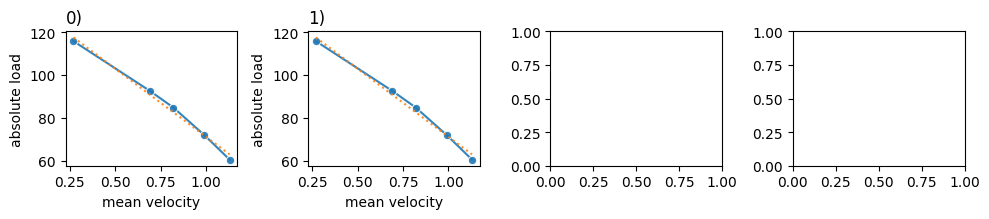

In [1002]:
sample_mean2 = sample_mean.copy()
sample_mean2['100%MV'] = 0.27 # Since this is not available, use same value as from data set
sample_mean2 = pd.concat([sample_mean2, sample_mean2], axis=0)
sample_mean2.index=[0,1]
sns.reset_defaults()
plot_profiles_lr(reshape_group_df_lr(sample_mean2))

# *End of Page*